<a href="https://colab.research.google.com/github/ahmadryan/covid19/blob/master/coronavirus_models_qudsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**a quick, possibly (certainly) buggy analysis of the cornavirus data on Kaggle https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset**

Visualizing the number of deaths, and the presence of the virus by country

TODO: 
* export the bokeh interactive plot to the web
* normalize by population
* review and kill bugs
* review and simplify syntax
* review and comment for posterity

In [1]:
!pip install geopandas
!pip install shapely

     |████████████████████████████████| 931kB 5.0MB/s 
     |████████████████████████████████| 10.4MB 26.2MB/s 
     |████████████████████████████████| 14.7MB 48.7MB/s 


In [2]:
import pandas as pd
import pylab as pl
import geopandas as gpd
import shapely
import json
import matplotlib as mpl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
#remove warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [0]:
#bokeh imports
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models import HoverTool
from bokeh.palettes import viridis, inferno, cividis, plasma, gray

In [0]:
#does not work on colab
#!pip install panel
#import panel as pn
#import panel.widgets as pnw
#pn.extension()
#output_notebook()
#output_file("test.html")


In [5]:
# most of the data I grab from online links 
# but the shapefiles downloaded and saved on data/
# the last part of the analysis uses worldbank data 
# which I also downloaded and saved on data/ - that could be changed
from google.colab import drive

drive.mount("/content/gdrive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
cd gdrive/My\ Drive


/content/gdrive/My Drive


In [7]:
cd cv19/covid_data/

/content/gdrive/My Drive/cv19/covid_data


# COVID-19 death analysis



In [0]:
# JHU database on COVID-19
root = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
# get the number of dead people
deaths = pd.read_csv(root + "/time_series_19-covid-Deaths.csv")
confirmed = pd.read_csv(root + "/time_series_19-covid-Confirmed.csv")

In [505]:
deaths.describe()

Lat        Long  ...      3/21/20      3/22/20
count  487.000000  487.000000  ...   487.000000   487.000000
mean    30.580962  -33.601551  ...    26.638604    30.045175
std     19.645817   81.064011  ...   277.916522   307.811233
min    -41.454500 -157.858400  ...     0.000000     0.000000
25%     24.000000  -91.733100  ...     0.000000     0.000000
50%     37.545500  -73.794900  ...     0.000000     0.000000
75%     42.171200   22.380900  ...     1.000000     1.000000
max     71.706900  178.065000  ...  4825.000000  5476.000000

[8 rows x 63 columns]

In [506]:
confirmed.describe()

Lat        Long  ...       3/21/20       3/22/20
count  487.000000  487.000000  ...    487.000000    487.000000
mean    30.580962  -33.601551  ...    625.305955    689.845996
std     19.645817   81.064011  ...   4397.961371   4658.551576
min    -41.454500 -157.858400  ...      0.000000      0.000000
25%     24.000000  -91.733100  ...      0.000000      0.000000
50%     37.545500  -73.794900  ...      3.000000      4.000000
75%     42.171200   22.380900  ...    125.000000    138.500000
max     71.706900  178.065000  ...  67800.000000  67800.000000

[8 rows x 63 columns]

In [507]:
deaths.head()

Province/State Country/Region      Lat  ...  3/20/20  3/21/20  3/22/20
0            NaN       Thailand  15.0000  ...        1        1        1
1            NaN          Japan  36.0000  ...       33       35       40
2            NaN      Singapore   1.2833  ...        0        2        2
3            NaN          Nepal  28.1667  ...        0        0        0
4            NaN       Malaysia   2.5000  ...        3        4       10

[5 rows x 65 columns]

In [508]:
confirmed.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20'],
      dtype='object')

In [509]:
where( deaths['Country/Region'] == 'US' )[0]

array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 33

In [510]:
firstdate = pd.to_datetime(deaths.columns[4])
firstdate

Timestamp('2020-01-22 00:00:00')

In [511]:
deaths.head()

Province/State Country/Region      Lat  ...  3/20/20  3/21/20  3/22/20
0            NaN       Thailand  15.0000  ...        1        1        1
1            NaN          Japan  36.0000  ...       33       35       40
2            NaN      Singapore   1.2833  ...        0        2        2
3            NaN          Nepal  28.1667  ...        0        0        0
4            NaN       Malaysia   2.5000  ...        3        4       10

[5 rows x 65 columns]

In [0]:
# last day contains the cumulative death rate
deaths["totaldeaths"] = deaths[deaths.columns[-1]]
confirmed["totalconfirmed"] = confirmed[confirmed.columns[-1]]


In [0]:
# combine lat and lon to one column
lonlat_deaths = list(zip(deaths.Long, 
                  deaths.Lat))

lonlat_confirmed = list(zip(confirmed.Long, 
                  confirmed.Lat))

In [514]:
deaths.tail()

Province/State Country/Region      Lat  ...  3/21/20  3/22/20  totaldeaths
482            NaN       Dominica  15.4150  ...        0        0            0
483            NaN        Grenada  12.1165  ...        0        0            0
484            NaN     Mozambique -18.6657  ...        0        0            0
485            NaN          Syria  34.8021  ...        0        0            0
486            NaN    Timor-Leste  -8.8742  ...        0        0            0

[5 rows x 66 columns]

In [515]:
confirmed.tail()

Province/State Country/Region      Lat  ...  3/21/20  3/22/20  totalconfirmed
482            NaN       Dominica  15.4150  ...        0        1               1
483            NaN        Grenada  12.1165  ...        0        1               1
484            NaN     Mozambique -18.6657  ...        0        1               1
485            NaN          Syria  34.8021  ...        0        1               1
486            NaN    Timor-Leste  -8.8742  ...        0        1               1

[5 rows x 66 columns]

In [516]:
# creating the geometry
# Create Point Geometry for based on lonlat column

deaths.reset_index(inplace=True)
deaths = gpd.GeoDataFrame(deaths)
deaths["lonlat"] = lonlat_deaths

deaths['geometry'] = deaths[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
deaths.head()

index Province/State  ...              lonlat                    geometry
0      0            NaN  ...       (101.0, 15.0)  POINT (101.00000 15.00000)
1      1            NaN  ...       (138.0, 36.0)  POINT (138.00000 36.00000)
2      2            NaN  ...  (103.8333, 1.2833)   POINT (103.83330 1.28330)
3      3            NaN  ...    (84.25, 28.1667)   POINT (84.25000 28.16670)
4      4            NaN  ...        (112.5, 2.5)   POINT (112.50000 2.50000)

[5 rows x 69 columns]

In [517]:
# creating the geometry
# Create Point Geometry for based on lonlat column

confirmed.reset_index(inplace=True)
confirmed = gpd.GeoDataFrame(confirmed)
confirmed["lonlat"] = lonlat_confirmed

confirmed['geometry'] = confirmed[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
confirmed.head()

index Province/State  ...              lonlat                    geometry
0      0            NaN  ...       (101.0, 15.0)  POINT (101.00000 15.00000)
1      1            NaN  ...       (138.0, 36.0)  POINT (138.00000 36.00000)
2      2            NaN  ...  (103.8333, 1.2833)   POINT (103.83330 1.28330)
3      3            NaN  ...    (84.25, 28.1667)   POINT (84.25000 28.16670)
4      4            NaN  ...        (112.5, 2.5)   POINT (112.50000 2.50000)

[5 rows x 69 columns]

In [461]:
!ls

age.csv
COVID-19-confirmed-2020-01-22-2020-03-22_5fps.mp4
COVID-19-deaths-2020-01-22-2020-03-22_1fps.mp4
COVID-19-deaths-2020-01-22-2020-03-22_5fps.mp4
covid-19-tests-country.csv
gdp.csv
gdpgrowth.csv
land.csv
pop.csv
populationGDP.csv
time_series_19-covid-Confirmed.csv
time_series_19-covid-Deaths.csv
time_series_19-covid-Recovered.csv
TM_WORLD_BORDERS_SIMPL-0.3.dbf
TM_WORLD_BORDERS_SIMPL-0.3.prj
TM_WORLD_BORDERS_SIMPL-0.3.shp
TM_WORLD_BORDERS_SIMPL-0.3.shx
urban.csv


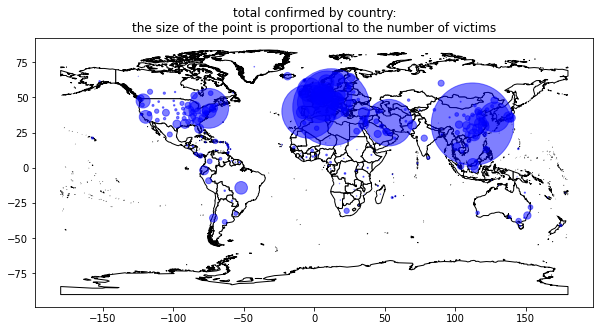

In [518]:
world = gpd.GeoDataFrame.from_file("TM_WORLD_BORDERS_SIMPL-0.3.shp")
ax = world.plot(figsize=(10,10), edgecolor="k", facecolor="w")
confirmed.plot(ax=ax, #column="Country/Region", 
            markersize=confirmed.totalconfirmed * 0.1, alpha=0.5, color='Blue')
ax.axis("on")
ax.set_title("total confirmed by country:\n" + 
             "the size of the point is proportional to the number of victims" );

In [343]:
india =  world[world.NAME == "India"]
type(india)

geopandas.geodataframe.GeoDataFrame

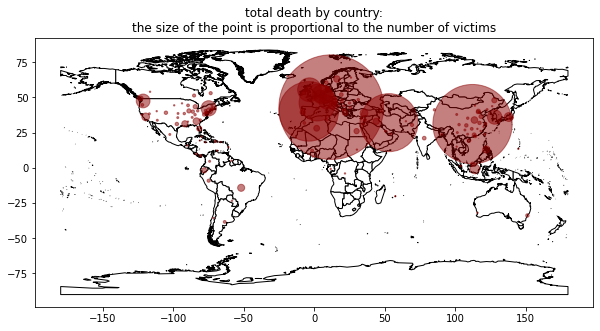

In [519]:
world = gpd.GeoDataFrame.from_file("TM_WORLD_BORDERS_SIMPL-0.3.shp")
ax = world.plot(figsize=(10,10), edgecolor="k", facecolor="w")
deaths.plot(ax=ax, #column="Country/Region", 
            markersize=deaths.totaldeaths * 2, alpha=0.5, color='DarkRed')
ax.axis("on")
ax.set_title("total death by country:\n" + 
             "the size of the point is proportional to the number of victims" );

#ax.set_xlim(67, 97)
#ax.set_ylim(7, 38);

In [0]:
# I want the data as granular as country. 
# More granular would be great but I could not map it wasily 
# (I would need to find a map of provinces worldwide 
# and do a lot of name matching to merge properly)
deaths["Country/Region"].replace("Mainland China", "China", inplace=True)
deaths["Country/Region"].replace("UK", "United Kingdom", inplace=True)
deaths["Country/Region"].replace("US", "United States", inplace=True)
deaths = deaths.groupby("Country/Region").sum()
deaths['logtotaldeaths'] = np.log10(deaths['totaldeaths'] + 1)

confirmed["Country/Region"].replace("Mainland China", "China", inplace=True)
confirmed["Country/Region"].replace("UK", "United Kingdom", inplace=True)
confirmed["Country/Region"].replace("US", "United States", inplace=True)
confirmed = confirmed.groupby("Country/Region").sum()
#confirmed['logtotalconfirmed'] = np.log10(confirmed['totalconfirmed'] + 1)

In [521]:
confirmed.head()

index      Lat     Long  ...  3/21/20  3/22/20  totalconfirmed
Country/Region                           ...                                  
Afghanistan        26  33.0000  65.0000  ...       24       40              40
Albania            95  41.1533  20.1683  ...       76       89              89
Algeria            29  28.0339   1.6596  ...      139      201             201
Andorra            60  42.5063   1.5218  ...       88      113             113
Angola            470 -11.2027  17.8739  ...        2        2               2

[5 rows x 65 columns]

In [0]:
deaths["firstoccurrence"] = np.zeros(len(deaths)) * np.nan
for i in deaths.index:
    done = False
    for j in range(0, len(deaths.columns)):
        #print(i,j, deaths.iloc[i,j], done)
        if done:
            break
        try :
          pd.to_datetime(deaths.columns[j])
        except ValueError:
          continue
        #print(i, j, deaths.iloc[i,j])
        if (deaths.loc[i][j]) > 0: 
            #print("\t", i,j, deaths.iloc[i,j], done)
            deaths.loc[i, "firstoccurrence"] = pd.to_datetime(deaths.columns[j])          
            done = True

confirmed["firstoccurrence"] = np.zeros(len(confirmed)) * np.nan
for i in confirmed.index:
    done = False
    for j in range(0, len(confirmed.columns)):
        #print(i,j, confirmed.iloc[i,j], done)
        if done:
            break
        try :
          pd.to_datetime(confirmed.columns[j])
        except ValueError:
          continue
        #print(i, j, confirmed.iloc[i,j])
        if (confirmed.loc[i][j]) > 0: 
            #print("\t", i,j, confirmed.iloc[i,j], done)
            confirmed.loc[i, "firstoccurrence"] = pd.to_datetime(confirmed.columns[j])          
            done = True

In [523]:
deaths["firstoccurrence"] 

Country/Region
Afghanistan    2020-03-22 00:00:00
Albania        2020-03-11 00:00:00
Algeria        2020-03-12 00:00:00
Andorra        2020-03-22 00:00:00
Angola                         NaN
                      ...         
Uzbekistan                     NaN
Venezuela                      NaN
Vietnam                        NaN
Zambia                         NaN
Zimbabwe                       NaN
Name: firstoccurrence, Length: 171, dtype: object

In [524]:
deaths.iloc[0, 0], deaths.iloc[0, j], i, j, deaths.columns[j]

(26, 0, 'Zimbabwe', 62, '3/21/20')

In [525]:
confirmed.iloc[0, 0], confirmed.iloc[0, j], i, j, confirmed.columns[j]

(26, 24, 'Zimbabwe', 62, '3/21/20')

In [526]:
deaths.describe()

index          Lat  ...  totaldeaths  logtotaldeaths
count    171.000000   171.000000  ...   171.000000      171.000000
mean     692.052632    87.093150  ...    85.567251        0.482621
std     5080.963512   733.270913  ...   521.078847        0.749171
min        0.000000  -220.525800  ...     0.000000        0.000000
25%       49.000000     6.425950  ...     0.000000        0.000000
50%       97.000000    21.000000  ...     1.000000        0.301030
75%      435.500000    42.109150  ...     3.500000        0.650515
max    66264.000000  9531.003400  ...  5476.000000        3.738543

[8 rows x 66 columns]

In [527]:
confirmed.describe()

index          Lat  ...       3/22/20  totalconfirmed
count    171.000000   171.000000  ...    171.000000      171.000000
mean     692.052632    87.093150  ...   1964.649123     1964.649123
std     5080.963512   733.270913  ...   8740.262382     8740.262382
min        0.000000  -220.525800  ...      1.000000        1.000000
25%       49.000000     6.425950  ...      5.500000        5.500000
50%       97.000000    21.000000  ...     76.000000       76.000000
75%      435.500000    42.109150  ...    388.000000      388.000000
max    66264.000000  9531.003400  ...  81397.000000    81397.000000

[8 rows x 65 columns]

In [528]:
print ("as of {}".format(pd.to_datetime("today").date()))
print ("number of countries in the database {:d}".format(len(deaths)))
print ("number of countries with at least 1 death {:d}".format(
    (deaths.totaldeaths > 0).sum()))
print ("number of countries with at least 1 confirmed case {:d}".format(
    (confirmed.totalconfirmed > 0).sum()))

as of 2020-03-23
number of countries in the database 171
number of countries with at least 1 death 87
number of countries with at least 1 confirmed case 171


In [529]:
# how many days are in the database?
maxday = pd.Timedelta(pd.to_datetime("today").normalize() - pd.to_datetime("01/01/2020"))
maxday -= pd.Timedelta(2, unit="day")
maxday

Timedelta('80 days 00:00:00')

In [530]:
# it will be convenient to have the log number, instead of the natural number, 
# or maps will have too much contrast 
# I am adding it to columns with columname the date, but as a string
def addlogbydate(df):
  for d in df.columns:
    try :
      pd.to_datetime(d)
    except ValueError:
      continue
    df[pd.to_datetime(d).strftime('%Y-%m-%d')] = df[d]
  return df
deaths = addlogbydate(deaths).reset_index()
confirmed = addlogbydate(confirmed).reset_index()
deaths

Country/Region  index      Lat  ...  2020-03-20  2020-03-21  2020-03-22
0      Afghanistan     26  33.0000  ...           0           0           1
1          Albania     95  41.1533  ...           2           2           2
2          Algeria     29  28.0339  ...          11          15          17
3          Andorra     60  42.5063  ...           0           0           1
4           Angola    470 -11.2027  ...           0           0           0
..             ...    ...      ...  ...         ...         ...         ...
166     Uzbekistan    439  41.3775  ...           0           0           0
167      Venezuela    421   6.4238  ...           0           0           0
168        Vietnam    191  16.0000  ...           0           0           0
169         Zambia    456 -15.4167  ...           0           0           0
170       Zimbabwe    476 -20.0000  ...           0           0           0

[171 rows x 129 columns]

In [531]:
confirmed

Country/Region  index      Lat  ...  2020-03-20  2020-03-21  2020-03-22
0      Afghanistan     26  33.0000  ...          24          24          40
1          Albania     95  41.1533  ...          70          76          89
2          Algeria     29  28.0339  ...          90         139         201
3          Andorra     60  42.5063  ...          75          88         113
4           Angola    470 -11.2027  ...           1           2           2
..             ...    ...      ...  ...         ...         ...         ...
166     Uzbekistan    439  41.3775  ...          33          43          43
167      Venezuela    421   6.4238  ...          42          70          70
168        Vietnam    191  16.0000  ...          91          94         113
169         Zambia    456 -15.4167  ...           2           2           3
170       Zimbabwe    476 -20.0000  ...           1           3           3

[171 rows x 128 columns]

In [0]:
def get_dataset(df=None, day=None, key="firstoccurrence"):
    ''' this produces a geodataframe by country with the number of deaths by day
    df: the dataframe with covid data
    day: the date to be plotted in days since 01/01/2020
    key: only used if day is None - name of a column, it will extract data for that column
    returns the dataframe combined with a world map and converted to a dataframe, the column used'''
    if day is None:
      newt = key
      print('Day was None')
    else:
      newt = (pd.to_datetime("1/1/2020") + pd.Timedelta(day, "D")).strftime('%Y-%m-%d')

    if newt not in df.columns:
        newt = firstdate.strftime('%Y-%m-%d')
    
    worlddeaths = world[["NAME", "geometry"]].merge(
        df[["Country/Region", newt]], 
        left_on="NAME", right_on="Country/Region", how="left")
    
    worlddeaths = gpd.GeoDataFrame(worlddeaths.groupby("NAME").sum().reset_index(
    ).merge(worlddeaths[["NAME", "geometry"]].drop_duplicates(subset="NAME"), 
            on="NAME", how="left"))
    worlddeaths[newt] = worlddeaths[newt].fillna(0)
    
    return worlddeaths, newt
#get_dataset(1)

In [533]:
key_deaths

'2020-01-22'

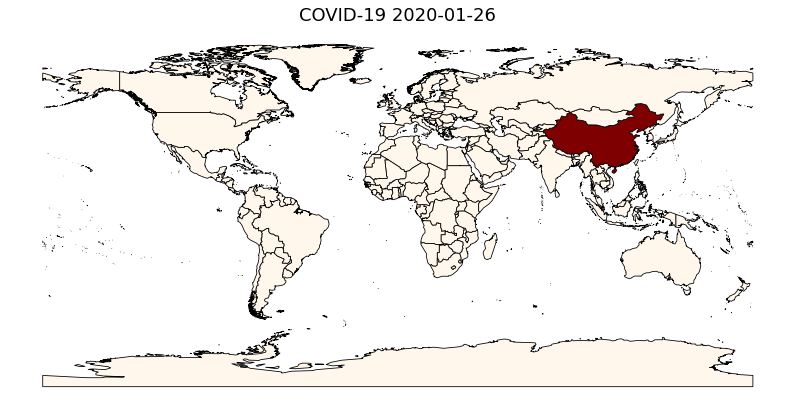

In [534]:
data_deaths, key_deaths = get_dataset(df=deaths, day=25)

fig, ax = plt.subplots(1, figsize=(14, 8))
data_deaths.plot(column=key_deaths, 
          clim=(0,100), cmap='OrRd', 
          linewidth=0.8, ax=ax, edgecolor='black')
ax.axis('off')
ax.set_title('COVID-19 %s'%key_deaths, fontsize=18);

In [535]:
data_deaths.head()

NAME  ...                                           geometry
0     Afghanistan  ...  POLYGON ((74.91574 37.23733, 74.39221 37.17507...
1         Albania  ...  POLYGON ((19.43621 41.02107, 19.60056 41.79666...
2         Algeria  ...  POLYGON ((2.96361 36.80222, 4.78583 36.89472, ...
3  American Samoa  ...  MULTIPOLYGON (((-170.54251 -14.29750, -170.560...
4         Andorra  ...  POLYGON ((1.78172 42.56996, 1.72361 42.50944, ...

[5 rows x 3 columns]

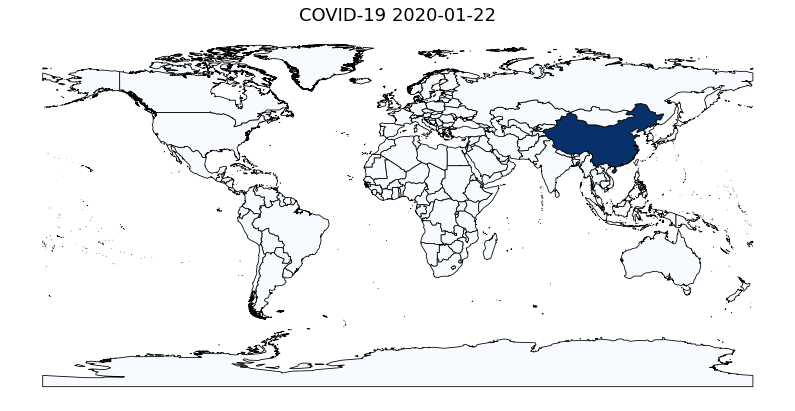

In [537]:
data_confirmed, key_confirmed = get_dataset(df=confirmed, day=90)

fig, ax = plt.subplots(1, figsize=(14, 8))
data_confirmed.plot(column=key_confirmed, 
          clim=(0,100), cmap='Blues', 
          linewidth=0.8, ax=ax, edgecolor='black')
ax.axis('off')
ax.set_title('COVID-19 %s'%key_confirmed, fontsize=18);

In [0]:
# this is for a dynamic bokeh map that does not work on google colab
def map_dash():
    """Map dashboard"""

    from bokeh.models.widgets import DataTable
    map_pane = pn.pane.Bokeh(width=400, height=300)
    #data_select = pnw.Select(name='dataset',options=list(
    #    datatmp))
    day_slider = pnw.IntSlider(start=22, end=90, value=25)
    
    def update_map(event):
        #data,key = get_dataset(day=0)
        #data = gpd.GeoDataFrame(data.groupby("NAME").sum().reset_index(
        #    ).merge(data[["NAME", "geometry"]].drop_duplicates(subset="NAME"), 
        #        on="NAME", how="left"))#.plot()

        gdf,key = get_dataset(day=day_slider.value)        
        #print("here", gdf, key)
        map_pane.object = bokeh_plot_map(gdf, key)        
        return
    day_slider.param.watch(update_map,'value')
    day_slider.param.trigger('value')
    #data_select.param.watch(update_map,'value')
    app = pn.Column(pn.Row("days since 01/01/2020", #data_select, 
        day_slider),map_pane)
    return app

#app = map_dash()
#app

In [539]:
deaths.describe()

index          Lat  ...   2020-03-21   2020-03-22
count    171.000000   171.000000  ...   171.000000   171.000000
mean     692.052632    87.093150  ...    75.865497    85.567251
std     5080.963512   733.270913  ...   471.210119   521.078847
min        0.000000  -220.525800  ...     0.000000     0.000000
25%       49.000000     6.425950  ...     0.000000     0.000000
50%       97.000000    21.000000  ...     0.000000     1.000000
75%      435.500000    42.109150  ...     3.000000     3.500000
max    66264.000000  9531.003400  ...  4825.000000  5476.000000

[8 rows x 127 columns]

In [0]:
for day in range(21, 90):
    data_deaths, key_deaths = get_dataset(df=deaths, day=day)
    fig, ax = plt.subplots(1, figsize=(14, 8))
    data_deaths.plot(column=key_deaths, cmap='OrRd', 
          linewidth=0.8, ax=ax, edgecolor='black', 
              legend=True, norm=mpl.colors.LogNorm(vmin=1, vmax=5000))
    
    ax.axis('off')
    ax.set_title('COVID-19, %s total deaths in log scale'%key_deaths, fontsize=18);
    pl.savefig("../figures/deaths/COVID-19-deaths-%s.png"%key_deaths)
    #pl.show()
    pl.close(fig)

In [191]:
data_deaths.describe()

2020-03-21
count   246.000000
mean     45.947154
std     382.152221
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max    4825.000000

In [397]:
for day in range(21, 90):
    data_confirmed, key_confirmed = get_dataset(df=confirmed, day=day)
    fig, ax = plt.subplots(1, figsize=(14, 8))
    data_confirmed.plot(column=key_confirmed, cmap='Blues', 
          linewidth=0.8, ax=ax, edgecolor='black', 
              legend=True, norm=mpl.colors.LogNorm(vmin=1, vmax=2e5))
    
    ax.axis('off')
    ax.set_title('COVID-19, %s total confirmed cases in log scale'%key_confirmed, fontsize=18);
    pl.savefig("../figures/confirmed/COVID-19-confirmed-%s.png"%key_confirmed)
    #pl.show()
    pl.close(fig)

KeyError: ignored

In [195]:
data_confirmed.describe()

2020-03-21
count    246.000000
mean    1109.219512
std     6790.198004
min        0.000000
25%        0.000000
50%        3.000000
75%      122.250000
max    81305.000000

In [0]:
import cv2
import glob
import matplotlib.image as mpimg

In [398]:
img_array = []
file_list1 = sort( glob.glob('../figures/deaths/*.png') )
file_list2 = sort( glob.glob('../figures/confirmed/*.png') )

print( '%s relevant files found' %( len( file_list ) ) )


# Read all the images in the directories

for filename in file_list2 :

    img = cv2.imread( filename )
    height, width, layers = img.shape
    size = ( width, height )
    img_array.append( img )

# Start writing the images to videos

fourcc = cv2.VideoWriter_fourcc( *'GEOX' )

# Define the frame rate for video

fps = 5

# Define the video name and its extension

vid_name = file_list2[0][21:-4] + '-' + file_list[-1][-14:-4] + \
'_' + str( fps ) + 'fps.mp4'

out = cv2.VideoWriter( vid_name, fourcc, fps, size )

print( 'Writing images to video file' )

for i, xx in enumerate(img_array) :
    #xxc = uint8( xx.copy() )
    out.write( xx )
out.release()

61 relevant files found
Writing images to video file


In [0]:
for day in range(0,90):
    data_deaths,key_deaths = get_dataset(df=deaths, day=day)
    data_deaths["isit"] = data_deaths[key] > 0
    fig, ax = plt.subplots(1, figsize=(14, 8))
    data_deaths.plot(column="isit", cmap='OrRd', 
          linewidth=0.8, ax=ax, edgecolor='black', 
              vmin=0, vmax=1)
    
    ax.axis('off')
    ax.set_title('COVID-19, %s countries with confirmed deaths'%key, fontsize=18);
    pl.savefig("COVID-19-countireswdeath-%s.png"%key)
    pl.show()
    pl.close(fig)

# COVID-19 intection analysis


In [0]:
# from the JHU database
infected = gpd.GeoDataFrame(pd.read_csv(root + 
                                        "time_series_19-covid-Confirmed.csv"))

In [0]:
infected = infected.groupby("Country/Region").sum()
# number of dates in the database
N = infected.shape[1] - 2

In [0]:
infected.reset_index(inplace=True)
infected["Country/Region"].replace("Mainland China", "China", inplace=True)
infected["Country/Region"].replace("UK", "United Kingdom", inplace=True)
infected["Country/Region"].replace("US", "United States", inplace=True)

In [543]:
infected.iloc[:,3:N+3]

1/22/20  1/23/20  1/24/20  1/25/20  ...  3/19/20  3/20/20  3/21/20  3/22/20
0          0        0        0        0  ...       22       24       24       40
1          0        0        0        0  ...       64       70       76       89
2          0        0        0        0  ...       87       90      139      201
3          0        0        0        0  ...       53       75       88      113
4          0        0        0        0  ...        0        1        2        2
..       ...      ...      ...      ...  ...      ...      ...      ...      ...
166        0        0        0        0  ...       23       33       43       43
167        0        0        0        0  ...       42       42       70       70
168        0        2        2        2  ...       85       91       94      113
169        0        0        0        0  ...        2        2        2        3
170        0        0        0        0  ...        0        1        3        3

[171 rows x 61 columns]

In [0]:
infected["totalinfected"] = infected[infected.columns[-1]]
infected = addlogbydate(infected)

data, key = get_dataset(day=24, df=infected)
data = gpd.GeoDataFrame(data.groupby("NAME").sum().reset_index(
    ).merge(data[["NAME", "geometry"]].drop_duplicates(subset="NAME"), 
            on="NAME", how="left"))#.plot()


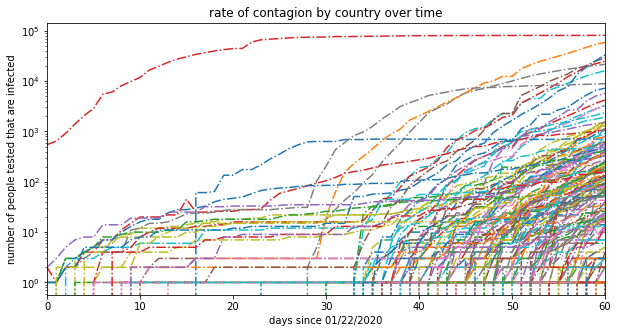

In [545]:
# the rate of contagion by country over time
def getcountry (df, country):
  return df[df["Country/Region"] == country].set_index("Country/Region")[
                  df.columns[3:N+3]].T.reset_index()

fig, ax = pl.subplots(1, 1, figsize=(10,5))
for country in infected["Country/Region"].values:

  tmp = getcountry(infected, country)#.set_index("Country/Region")
  tmp.plot(style="-.", 
           ax=ax, label=None,
           legend=False,
           #label=country, 
           figsize=(10,5))
pl.yscale("log")
pl.ylabel("number of people tested that are infected")
pl.xlabel("days since 01/22/2020")
pl.title("rate of contagion by country over time");

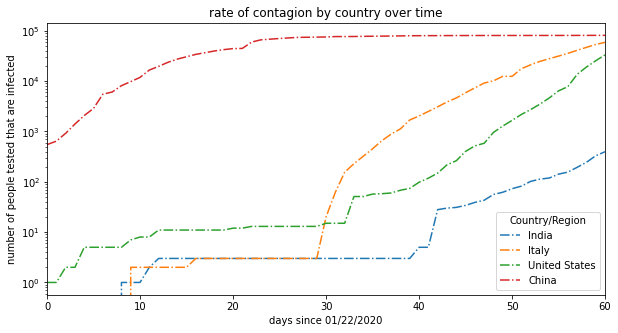

In [547]:
india = getcountry(infected, 'India')
italy = getcountry(infected, 'Italy')
us = getcountry(infected, 'United States')
china = getcountry(infected, 'China')

fig, ax = pl.subplots(1, 1, figsize=(10,5))

india.plot(style="-.", ax=ax,label='India', figsize=(10,5))
italy.plot(style="-.", ax=ax, label='Italy', figsize=(10,5))
us.plot(style="-.", ax=ax, label='US', figsize=(10,5))
china.plot(style="-.", ax=ax, label='China', figsize=(10,5))

pl.yscale("log")
pl.ylabel("number of people tested that are infected")
pl.xlabel("days since 01/22/2020")
pl.title("rate of contagion by country over time");
#plt.figure()
#plt.plot(india)

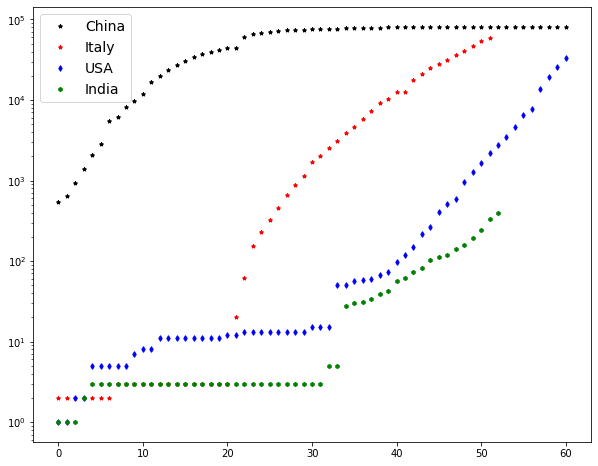

In [549]:
india = getcountry(infected, 'India')
italy = getcountry(infected, 'Italy')
us = getcountry(infected, 'United States')
china = getcountry(infected, 'China')

idx_itl = where( italy.Italy > 0 )[0]
idx_usa = where( us['United States'] > 0 )[0]
idx_ind = where( india.India > 0 )[0]
idx_chn = where( china.China > 0 )[0]

fig, ax = pl.subplots(1, 1, figsize=(10,8))

ax.plot( arange(len(idx_chn)), china.China[idx_chn],  'k*', label='China', ms=4 )
ax.plot( arange(len(idx_itl)), italy.Italy[idx_itl],  'r*', label='Italy', ms=4 )
ax.plot( arange(len(idx_usa)), us['United States'][idx_usa], 'bd', label='USA', ms=4 )
ax.plot( arange(len(idx_ind)), india.India[idx_ind], 'gh', label='India', ms=4 )
ax.set_yscale('log')
ax.legend(loc=2, fontsize=14);

In [550]:
idx_chn = where( china.China > 0 )[0]
len(idx_chn)

61

In [0]:
# combine with population data by country (using 2018 data from world bank)
df = infected.merge(pd.read_csv("pop.csv", skiprows=4)[[
                                                  "Country Name", "2018"]],
               left_on="Country/Region", right_on="Country Name")

In [552]:
output_notebook()

def bokeh_plot_ts(df, title='', p=None):
    """Plot bokeh map from GeoDF"""
    tmp = df.set_index("Country/Region")[df.columns[3:55]].T
    tmp["date"] = pd.to_datetime(tmp.index)
    tools = 'wheel_zoom,pan,reset,hover'
    if p is None: 
      p = figure(title=title,
                 plot_height=600, plot_width=600, 
               toolbar_location='right', tools=tools, 
               x_axis_type="datetime", y_axis_type="log")
    numlines = len(tmp.columns)
    mypalette = gray(numlines)
    colors = {}
    for i in range(numlines):
      colors[i] = mypalette[i]
    for i,(name, series) in enumerate(tmp.iteritems()):
      if name == 'date': continue
      name_for_display = np.tile(name, [len(tmp.index),1])

      source = ColumnDataSource({'x': tmp.date, 'y': series.values, 
              'series_name': name_for_display, 
              'Date': [tmp.date[i].strftime('%Y-%m-%d') for i in range(len(tmp))]})     
      p.line('x', 'y', source = source, line_alpha=0.3, line_width=3,
             line_color=colors[i], hover_line_alpha=1,)     

      hover = p.select(dict(type=HoverTool))
      hover.tooltips = [("Series", "@series_name"), 
                        ("Date", "@Date"),  
                        ("Value", "@y{0}"),]
      hover.mode = 'mouse'
    output_notebook()
    return p
tmp = infected.merge(#sort_values(by="totalinfected").merge(
    pd.read_csv("pop.csv", skiprows=4)[["Country Name", "2018"]],
               left_on="Country/Region", right_on="Country Name")

for i in range(len(tmp.index)):
  # normalize by population
  tmp.iloc[i, 3:N+3] = [0] + list(tmp.iloc[i,3+1:N+3].values - 
                                  tmp.iloc[i,3:N+2].values)
  tmp.iloc[i, 3:N+3] = tmp.iloc[i, 3:N+3].rolling(5, center=True,
                                                  min_periods=0).mean()
tmp
p = bokeh_plot_ts(tmp, title="daily rate of contagion (new cases) by country - " + 
                  "smoothed over a 5 days window"); 
show(p)

In [553]:
tmp = infected.merge(#sort_values(by="totalinfected").merge(
    pd.read_csv("pop.csv", skiprows=4)[["Country Name", "2018"]],
               left_on="Country/Region", right_on="Country Name")
tmp.head()

for i in range(len(tmp.index)):
  tmp.iloc[i, 3:N+3] = (np.array(tmp.iloc[i,3:N+3].values) / 
                        tmp.iloc[i]["2018"] * 1e6)
tmp
p = bokeh_plot_ts(tmp, title="infected per million people by country"); 
show(p)

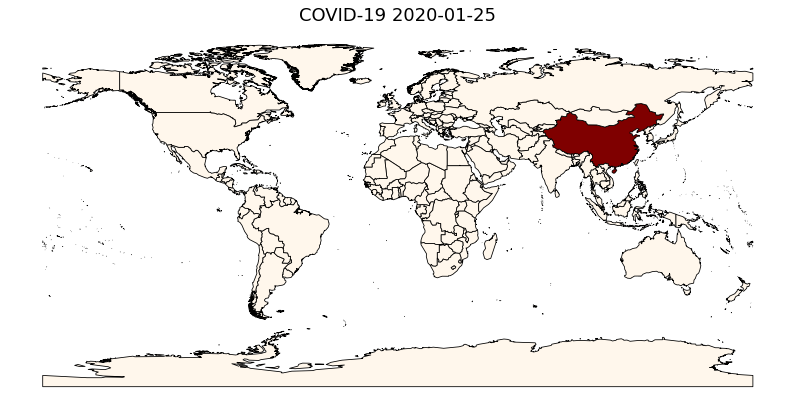

In [410]:
fig, ax = plt.subplots(1, figsize=(14, 8))
data.plot(column=key, 
          clim=(0,100), cmap='OrRd', 
          linewidth=0.8, ax=ax, edgecolor='black')
ax.axis('off')
ax.set_title('COVID-19 %s'%key, fontsize=18);

In [0]:
for day in range(0,90):
    data,key = get_dataset(day=day, df=infected)
    data["isit"] = data[key] > 0
    fig, ax = plt.subplots(1, figsize=(14, 8))
    data.plot(column="isit", cmap='OrRd', 
          linewidth=0.8, ax=ax, edgecolor='black', 
              vmin=0, vmax=1)
    
    ax.axis('off')
    ax.set_title('COVID-19, %s countries with confirmed cases'%key, fontsize=18);
    pl.savefig("figs/COVID-19-contagion-%s.png"%key)
    pl.show()
    pl.close(fig)

# But the entire analysis is affected by the rate at which people are tested, and possibly by the test themselves: do all test kits have the same false positive and false negative rates?

# Adding number of tests by country

In [0]:
tests = pd.read_csv('covid-19-tests-country.csv')

In [555]:
tests = tests.replace("United States - CDC samples tested", "United States").replace(
    "China - Guangdong", "China").rename(
    {"Total COVID-19 tests performed (Tests)":"tests"}, axis=1)
tests

Entity Code  Year   tests
0                                    Armenia  ARM    14     211
1   Australia - Australian Capital Territory  NaN    18     649
2                Australia - New South Wales  NaN    13    8008
3                                    Austria  AUT    18    6582
4                                    Bahrain  BHR    17    9201
5                           Canada - Alberta  NaN    17    4288
6                  Canada - British Columbia  NaN    11    2008
7                           Canada - Ontario  NaN    17    4185
8                                      China  NaN     0  320000
9                                    Croatia  HRV    14     344
10                            Czech Republic  CZE    17    2353
11                                   Denmark  DNK    18    3839
12                                   Finland  FIN    16     900
13                                    France  FRA    10    6628
14                                   Hungary  HUN    18     858
15                                   Iceland  ISL    16     856
16                                     India  IND    11    4058
17                                   Ireland  IRL    14    1784
18                                     Italy  ITA    17   86011
19                                     Japan  JPN    17   10205
20                                 Lithuania  LTU    18     366
21                                  Malaysia  MYS    17    4010
22                               Netherlands  NLD    12    6000
23                               New Zealand  NZL    16     338
24                                    Norway  NOR    17    8000
25                               Philippines  PHL    17     717
26                                    Poland  POL    17    2234
27                                    Russia  RUS    16   76963
28                                  Slovakia  SVK    17     853
29                                  Slovenia  SVN    17    3058
30                              South Africa  ZAF    16     645
31                               South Korea  KOR    18  248647
32                                    Taiwan  TWN    18   16089
33                                  Thailand  THA    17    5232
34                            United Kingdom  GBR    17   29764
35                             United States  NaN    17   13624
36    United States - COVID-Tracking project  NaN    17    7934
37                                   Vietnam  VNM    17    4588

out all the data together

In [0]:
infected["teninfected"] = [np.nan] * len(infected)
dates = []
for i,c in enumerate(infected.columns):
  if i > N+3:
    dates.append('')
    continue
  try: 
    dates.append(pd.to_datetime(c))
  except: 
    dates.append('')
dates = np.array(dates)

In [557]:
for c in infected["Country/Region"]:
  for day in range(0, 90):
    data = pd.DataFrame(infected[infected["Country/Region"] == c].T)
    if data[dates == (pd.to_datetime("01/01/2020") + 
                      pd.Timedelta(day, unit="days"))].values > 10:
      infected.loc[infected["Country/Region"] == c, ["teninfected"]] = day
      break


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


In [558]:
infected["teninfected"]

0      73.0
1      70.0
2      63.0
3      76.0
4       NaN
       ... 
166    77.0
167    75.0
168    38.0
169     NaN
170     NaN
Name: teninfected, Length: 171, dtype: float64

In [559]:
wtests = world[["NAME", "geometry"]].merge((infected[["Country/Region",
                      "totalinfected", "teninfected"]].merge(tests, left_on="Country/Region", 
                                       right_on="Entity").merge(
              deaths[['Country/Region', 'Lat', 'Long',
        'totaldeaths', 'logtotaldeaths', 
        'firstoccurrence']], on="Country/Region")), how="left", 
        left_on="NAME",
        right_on="Country/Region").merge(pd.read_csv("pop.csv", 
                             skiprows=4)[["Country Name", "2017"]].rename(
                          {"2017":"pop"}, axis=1), left_on="Country/Region", 
                          right_on="Country Name")
print("number of countries with reported number of tests", wtests.shape[0])

number of countries with reported number of tests 26


In [0]:
# calculate tests per person and per million ppl, 
# death per 100,000 ppl, 
# ratio of dead to tested and infected to tested people
wtests["testspp"] = wtests["tests"] / wtests["pop"]
wtests["deathpM"] = wtests["totaldeaths"] / wtests["pop"] * 1e5
wtests["testspM"] = wtests["tests"] / wtests["pop"] * 1e3
wtests["dead2test"] = wtests["totaldeaths"] / wtests["tests"]
wtests["infected2test"] = wtests["totalinfected"] / wtests["tests"]
wtests["logtests"] = np.log(wtests["tests"] + 1)

In [577]:
wtests["totalinfected"]

NAME
Armenia             194.0
Bahrain             332.0
China             81397.0
Denmark            1514.0
Ireland             906.0
Austria            3244.0
Finland             626.0
France            16176.0
Croatia             254.0
Hungary             131.0
Iceland             568.0
India               396.0
Italy             59138.0
Japan              1086.0
Lithuania           131.0
Malaysia           1306.0
Netherlands        4216.0
Norway             2383.0
New Zealand          66.0
Poland              634.0
Philippines         380.0
South Africa        274.0
Slovenia            414.0
Thailand            599.0
United Kingdom     5741.0
United States     33272.0
Name: totalinfected, dtype: float64

In [578]:
wtests["tests"]

NAME
Armenia              211.0
Bahrain             9201.0
China             320000.0
Denmark             3839.0
Ireland             1784.0
Austria             6582.0
Finland              900.0
France              6628.0
Croatia              344.0
Hungary              858.0
Iceland              856.0
India               4058.0
Italy              86011.0
Japan              10205.0
Lithuania            366.0
Malaysia            4010.0
Netherlands         6000.0
Norway              8000.0
New Zealand          338.0
Poland              2234.0
Philippines          717.0
South Africa         645.0
Slovenia            3058.0
Thailand            5232.0
United Kingdom     29764.0
United States      13624.0
Name: tests, dtype: float64

In [581]:
16176.0/6628.0,33272.0/13624.0

(2.44055522027761, 2.4421608925425717)

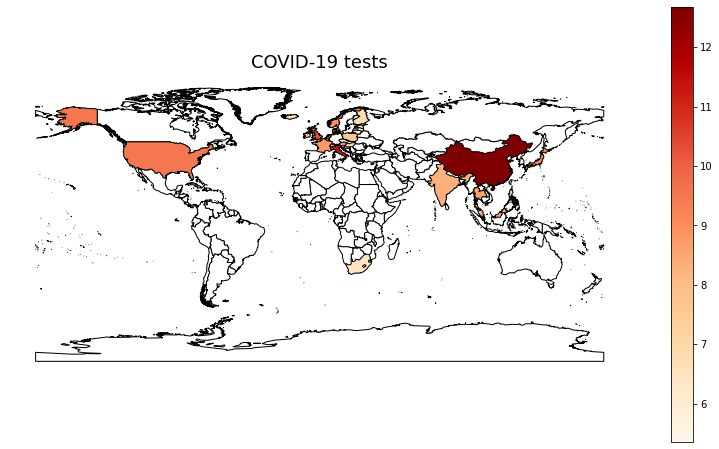

In [566]:
fig, ax = plt.subplots(1, figsize=(14, 8))
world.plot(ax=ax, edgecolor="k", facecolor="w")
wtests.fillna(0).plot(column="logtests", cmap="OrRd",
          linewidth=0.8, ax=ax, edgecolor='black',
          legend=True)
ax.axis('off')
ax.set_title('COVID-19 tests', fontsize=18);


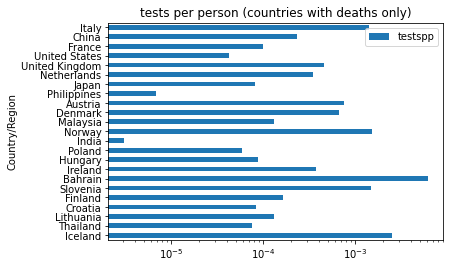

In [590]:
wtests[["testspp", "Country/Region", "totaldeaths"]][wtests.totaldeaths > 0
        ].sort_values(by="totaldeaths").set_index("Country/Region").plot(
            kind="barh", y="testspp");
pl.title("tests per person (countries with deaths only)");
pl.xscale('log')

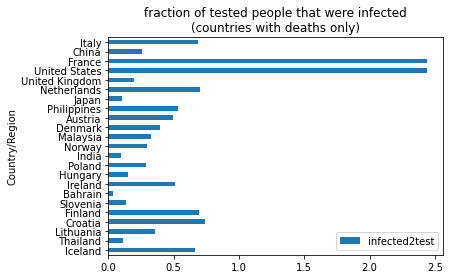

In [568]:
wtests[["infected2test", "Country/Region", "totaldeaths"]][wtests.totaldeaths > 0
        ].sort_values(by="totaldeaths").set_index("Country/Region").plot(
            kind="barh", y="infected2test")
pl.title("fraction of tested people that were infected\n" + 
         "(countries with deaths only)");

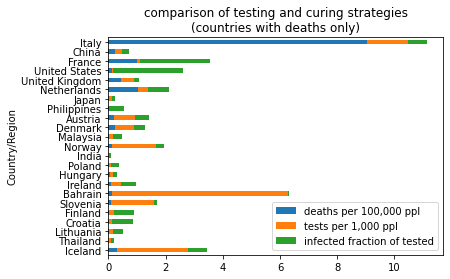

In [571]:
wtests[wtests.totaldeaths > 0
        ].sort_values(by="totaldeaths").set_index("Country/Region")[[
     "deathpM", "testspM", "infected2test"]].rename({"deathpM":
                                                     "deaths per 100,000 ppl", 
                            "infected2test":"infected fraction of tested", 
                            "testspM":"tests per 1,000 ppl"}, axis=1
         
     ).plot(kind="barh", stacked=True)
pl.title("comparison of testing and curing strategies\n" +
         "(countries with deaths only)");
#pl.xscale('log')

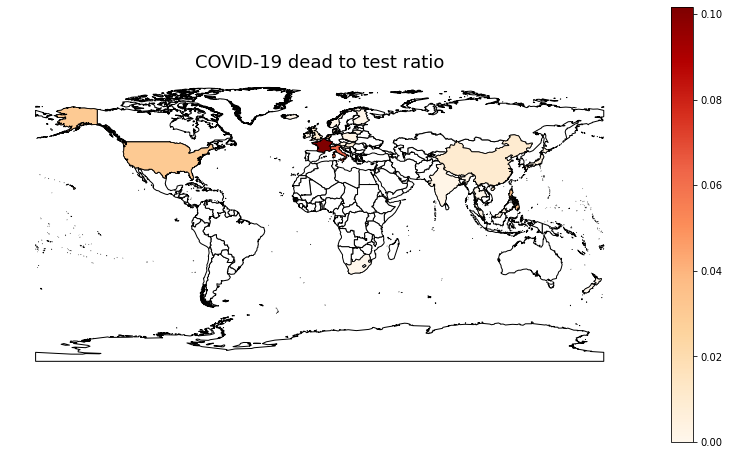

In [591]:
fig, ax = plt.subplots(1, figsize=(14, 8))
world.plot(ax=ax, edgecolor="k", facecolor="w")
wtests.fillna(0).plot(column="dead2test", cmap="OrRd",
          linewidth=0.8, ax=ax, edgecolor='black',
          legend=True)
ax.axis('off')
ax.set_title('COVID-19 dead to test ratio', fontsize=18);

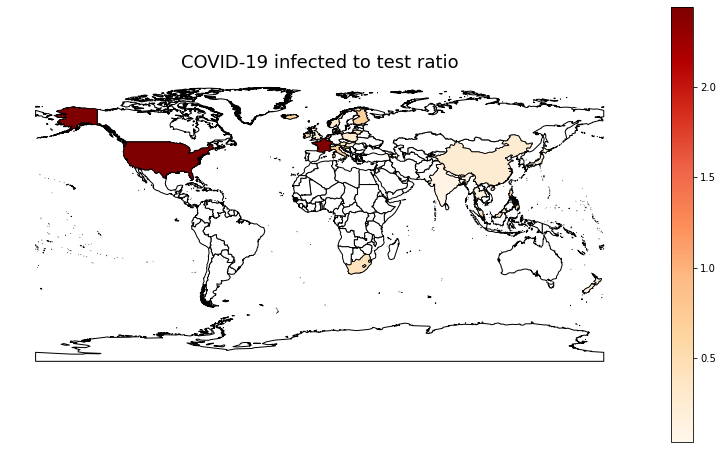

In [596]:
fig, ax = plt.subplots(1, figsize=(14, 8))
world.plot(ax=ax, edgecolor="k", facecolor="w")
wtests.fillna(0).plot(column="infected2test", cmap="OrRd",
          linewidth=0.8, ax=ax, edgecolor='black',
          legend=True)
ax.axis('off')
ax.set_title('COVID-19 infected to test ratio', fontsize=18);


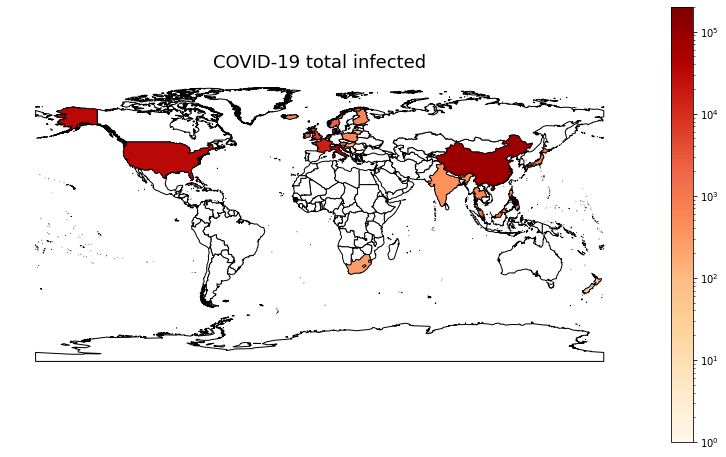

In [597]:
fig, ax = plt.subplots(1, figsize=(14, 8))
world.plot(ax=ax, edgecolor="k", facecolor="w")
wtests.fillna(0).plot(column="totalinfected", cmap="OrRd",
          linewidth=0.8, ax=ax, edgecolor='black',
          legend=True, norm=mpl.colors.LogNorm(vmin=1, vmax=2e5))
ax.axis('off')
ax.set_title('COVID-19 total infected', fontsize=18);


In [598]:
wtests.set_index("NAME", inplace=True)

KeyError: ignored

In [600]:
wtests.index

Index(['Armenia', 'Bahrain', 'China', 'Denmark', 'Ireland', 'Austria',
       'Finland', 'France', 'Croatia', 'Hungary', 'Iceland', 'India', 'Italy',
       'Japan', 'Lithuania', 'Malaysia', 'Netherlands', 'Norway',
       'New Zealand', 'Poland', 'Philippines', 'South Africa', 'Slovenia',
       'Thailand', 'United Kingdom', 'United States'],
      dtype='object', name='NAME')

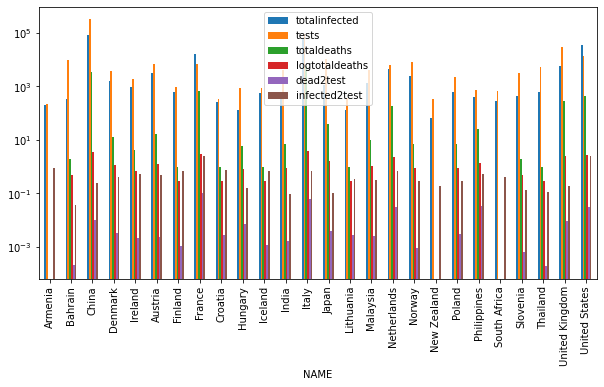

In [615]:
wtests[['totalinfected', 'tests', 'totaldeaths', 'logtotaldeaths',
       'dead2test', 'infected2test']][wtests.totalinfected > 0].plot(kind='bar',
                            figsize=(10, 5))
pl.yscale('log')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


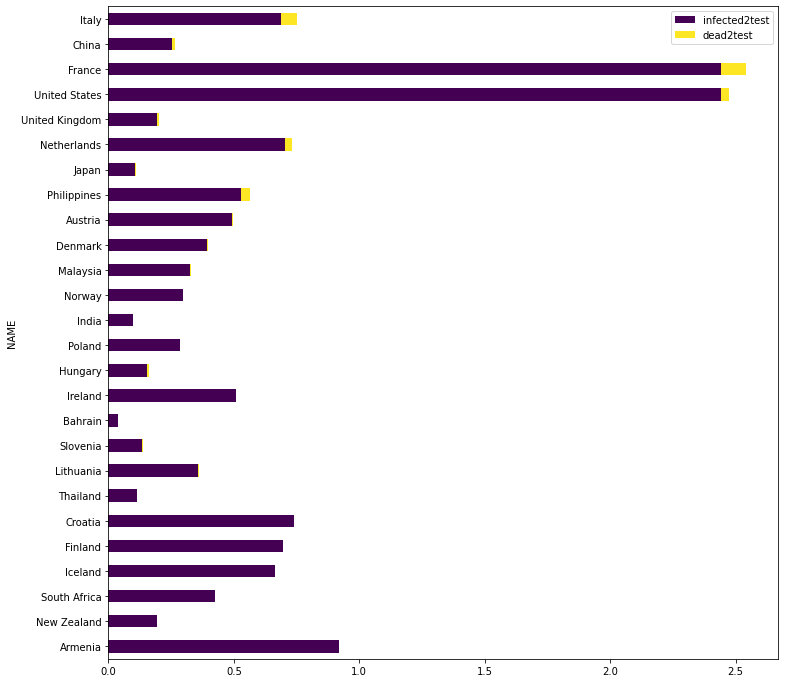

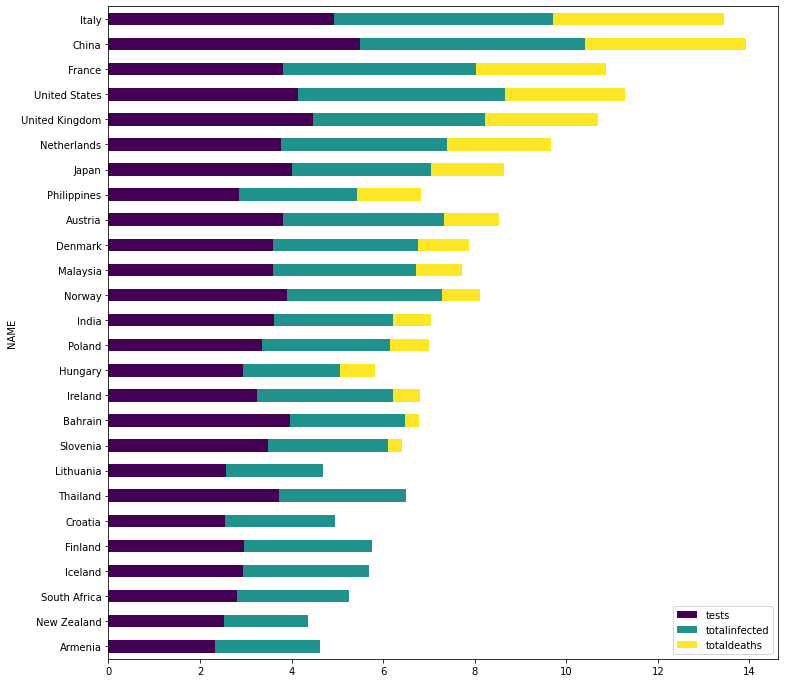

In [616]:
wtestsnormed = wtests[['tests', 
                       'totalinfected', 'totaldeaths',
                       'infected2test', 'dead2test', "teninfected"
       ]][wtests.totalinfected > 0].sort_values(by="totaldeaths", ascending=True)

wtestsnormed[[ 'infected2test', 'dead2test']].plot(kind='barh', 
                                figsize=(12, 12), stacked=True, 
                  cmap='viridis')

np.log10(wtestsnormed[['tests', 
                       'totalinfected', 'totaldeaths']]).plot(kind='barh', 
                                figsize=(12, 12), stacked=True, 
                  cmap='viridis');

In [617]:
wtestsnormed

tests  totalinfected  ...  dead2test  teninfected
NAME                                     ...                        
Armenia            211.0          194.0  ...   0.000000         73.0
New Zealand        338.0           66.0  ...   0.000000         76.0
South Africa       645.0          274.0  ...   0.000000         70.0
Iceland            856.0          568.0  ...   0.001168         62.0
Finland            900.0          626.0  ...   0.001111         64.0
Croatia            344.0          254.0  ...   0.002907         65.0
Thailand          5232.0          599.0  ...   0.000191         27.0
Lithuania          366.0          131.0  ...   0.002732         74.0
Slovenia          3058.0          414.0  ...   0.000654         67.0
Bahrain           9201.0          332.0  ...   0.000217         55.0
Ireland           1784.0          906.0  ...   0.002242         65.0
Hungary            858.0          131.0  ...   0.006993         70.0
Poland            2234.0          634.0  ...   0.003133         67.0
India             4058.0          396.0  ...   0.001725         63.0
Norway            8000.0         2383.0  ...   0.000875         59.0
Malaysia          4010.0         1306.0  ...   0.002494         35.0
Denmark           3839.0         1514.0  ...   0.003386         63.0
Austria           6582.0         3244.0  ...   0.002431         60.0
Philippines        717.0          380.0  ...   0.034868         68.0
Japan            10205.0         1086.0  ...   0.003920         29.0
Netherlands       6000.0         4216.0  ...   0.030000         61.0
United Kingdom   29764.0         5741.0  ...   0.009475         54.0
United States    13624.0        33272.0  ...   0.030608         33.0
France            6628.0        16176.0  ...   0.101690         38.0
China           320000.0        81397.0  ...   0.010203         21.0
Italy            86011.0        59138.0  ...   0.063666         51.0

[26 rows x 6 columns]

In [620]:
socioec = pd.read_csv("gdp.csv", 
                      skiprows=4)[["Country Name", "2017"]].rename(
                          {"2017":"gdp"}, axis=1).merge(
                          pd.read_csv("pop.csv", 
                             skiprows=4)[["Country Name", "2017"]].rename(
                          {"2017":"pop"}, axis=1)).merge(
                          pd.read_csv("pop.csv",skiprows=4)[[
                          "Country Name", "2017"]].rename(
                          {"2017":"growth"}, axis=1)).merge(
                          pd.read_csv("land.csv",skiprows=4)[[
                          "Country Name", "2017"]].rename(
                          {"2017":"land"}, axis=1)).merge(
                          pd.read_csv("urban.csv",skiprows=4)[[
                          "Country Name", "2010"]].rename(
                          {"2010":"urban"}, axis=1)).merge(
                          pd.read_csv("age.csv",skiprows=4)[[
                          "Country Name", "2018"]].rename(
                          {"2018":"age"}, axis=1)).fillna(0)
socioec

Country Name           gdp         pop  ...       land         urban        age
0           Aruba  2.700559e+09    105366.0  ...      180.0    172.847748  13.550947
1     Afghanistan  2.019176e+10  36296400.0  ...   652860.0      0.000000   2.584927
2          Angola  1.221238e+11  29816748.0  ...  1246700.0   1427.029541   2.216374
3         Albania  1.302506e+10   2873457.0  ...    27400.0   1689.403809  13.744736
4         Andorra  3.013387e+09     77001.0  ...      470.0      0.000000   0.000000
..            ...           ...         ...  ...        ...           ...        ...
259        Kosovo  7.227700e+09   1830700.0  ...    10887.0      0.000000   0.000000
260   Yemen, Rep.  2.681870e+10  27834821.0  ...   527970.0   4703.399902   2.876270
261  South Africa  3.495541e+11  57000451.0  ...  1213090.0  53460.312500   5.318005
262        Zambia  2.586814e+10  16853688.0  ...   743390.0      0.000000   2.099678
263      Zimbabwe  2.281301e+10  14236745.0  ...   386850.0      0.000000   2.939524

[264 rows x 7 columns]

In [622]:
# for the urban fraction of population, the 2010 data is more complete
pd.read_csv("urban.csv",skiprows=4)[["2010"]]

2010
0      172.847748
1             NaN
2     1427.029541
3     1689.403809
4             NaN
..            ...
259           NaN
260   4703.399902
261  53460.312500
262           NaN
263           NaN

[264 rows x 1 columns]

In [623]:
formodeling = wtestsnormed.merge(socioec, left_index=True, right_on="Country Name")
formodeling.head()

tests  totalinfected  totaldeaths  ...       land         urban        age
8    211.0          194.0          0.0  ...    28470.0      0.000000  11.253818
178  338.0           66.0          0.0  ...   263310.0   8116.299805  15.652425
261  645.0          274.0          0.0  ...  1213090.0  53460.312500   5.318005
112  856.0          568.0          1.0  ...   100250.0   1023.837036  14.795093
73   900.0          626.0          1.0  ...   303910.0  20052.173830  21.720788

[5 rows x 13 columns]

In [0]:
formodeling["testpp"] = formodeling["tests"] / formodeling["pop"]
#formodeling["totaldeaths"] = formodeling["test"] / formodeling["pop"]
#formodeling["testpp"] = formodeling["test"] / formodeling["pop"]
formodeling.reset_index(inplace=True)

cannot predict the numner of tests from socioeconomics at all. R~0.2

In [625]:
import statsmodels.formula.api as smf
testpp = smf.ols(formula="testpp ~ gdp + pop + growth + " + 
                 "land + urban + age", data=formodeling).fit()
testpp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 testpp   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.9051
Date:                Mon, 23 Mar 2020   Prob (F-statistic):              0.497
Time:                        23:05:25   Log-Likelihood:                 139.39
No. Observations:                  26   AIC:                            -266.8
Df Residuals:                      20   BIC:                            -259.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0023      0.001      2.679      0.014       0.001       0.004
gdp         3.791e-16   3.83e-16      0.991      0.334   -4.19e-16    1.18e-15
pop        -6.716e-11    2.5e-11     -2.684      0.014   -1.19e-10    -1.5e-11
growth      6.684e-11    2.5e-11      2.669      0.015    1.46e-11    1.19e-10
land        -3.05e-10   4.79e-10     -0.637      0.532    -1.3e-09    6.94e-10
urban      -6.547e-09   7.51e-09     -0.872      0.394   -2.22e-08    9.11e-09
age           -0.0001   5.37e-05     -1.880      0.075      -0.000     1.1e-05
==============================================================================
Omnibus:                       20.543   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.975
Skew:                           1.685   Prob(JB):                     3.10e-07
Kurtosis:                       7.038   Cond. No.                     6.89e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

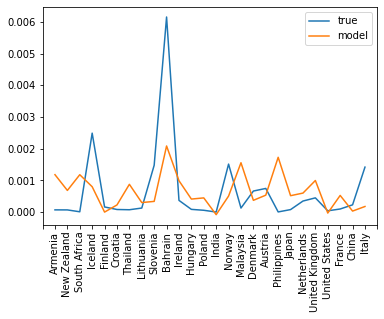

In [626]:
ax = formodeling[["testpp"]].plot(y="testpp",
                                  label="true")
pl.plot(testpp.predict(), label="model")
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + 
                   list(formodeling["Country Name"].values), rotation=90);
pl.legend();

The total number of infected individuals can be predicted to R~0.9 with dgb, land area, and urban fraction strong correlations. Urban fraction is again inversely proportional, but it improves the fit from 65 to 90%

In [627]:
totalinfected = smf.ols(formula="totalinfected ~ gdp +	pop	+ growth + " + 
                        "land	+ age", data=formodeling).fit()
totalinfected.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          totalinfected   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     7.022
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           0.000941
Time:                        23:05:32   Log-Likelihood:                -282.55
No. Observations:                  26   AIC:                             575.1
Df Residuals:                      21   BIC:                             581.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.249e+04   8890.146     -1.405      0.175    -3.1e+04    5999.505
gdp        -2.213e-09   2.47e-09     -0.897      0.380   -7.35e-09    2.92e-09
pop            0.0003      0.000      1.409      0.173      -0.000       0.001
growth        -0.0003      0.000     -1.401      0.176      -0.001       0.000
land           0.0095      0.005      1.829      0.082      -0.001       0.020
age          968.5409    545.241      1.776      0.090    -165.350    2102.432
==============================================================================
Omnibus:                       33.280   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.904
Skew:                           2.444   Prob(JB):                     1.35e-19
Kurtosis:                      10.505   Cond. No.                     6.88e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [628]:
totalinfected = smf.ols(formula="totalinfected ~ gdp +	pop	+ growth + " + 
                        "land	+ urban + age", data=formodeling).fit()
totalinfected.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          totalinfected   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     7.379
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           0.000459
Time:                        23:05:33   Log-Likelihood:                -280.00
No. Observations:                  26   AIC:                             572.0
Df Residuals:                      20   BIC:                             579.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6280.7631   8778.788     -0.715      0.483   -2.46e+04     1.2e+04
gdp          4.29e-09   3.87e-09      1.108      0.281   -3.79e-09    1.24e-08
pop            0.0002      0.000      0.727      0.476      -0.000       0.001
growth        -0.0002      0.000     -0.706      0.489      -0.001       0.000
land           0.0083      0.005      1.720      0.101      -0.002       0.018
urban         -0.1583      0.076     -2.083      0.050      -0.317       0.000
age          557.8562    543.460      1.026      0.317    -575.781    1691.494
==============================================================================
Omnibus:                       51.690   Durbin-Watson:                   0.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              296.183
Skew:                           3.715   Prob(JB):                     4.84e-65
Kurtosis:                      17.772   Cond. No.                     6.89e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

the total number of deaths is actually predicted farily well by the land area, and urban area, but it is inversely proportional to the urban area. The data on urban area is likely strongly based. Adding the tests per person does not improve the fit. GDP is mildely predictive. Adding the total number of infected people makes the death prediction ~90% accurate with **Italy being a strong outlier**

In [629]:
totaldeaths = smf.ols(formula="totaldeaths ~ gdp +	pop	+ growth	+ " + 
                      "land	+ urban + age", data=formodeling).fit()
totaldeaths.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totaldeaths   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.278
Date:                Mon, 23 Mar 2020   Prob (F-statistic):              0.312
Time:                        23:05:35   Log-Likelihood:                -217.55
No. Observations:                  26   AIC:                             447.1
Df Residuals:                      20   BIC:                             454.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -506.6240    794.869     -0.637      0.531   -2164.693    1151.445
gdp         1.958e-10   3.51e-10      0.558      0.583   -5.36e-10    9.27e-10
pop         1.501e-05   2.29e-05      0.655      0.520   -3.28e-05    6.28e-05
growth     -1.426e-05    2.3e-05     -0.621      0.541   -6.21e-05    3.36e-05
land           0.0002      0.000      0.522      0.607      -0.001       0.001
urban         -0.0070      0.007     -1.016      0.322      -0.021       0.007
age           45.4944     49.207      0.925      0.366     -57.150     148.139
==============================================================================
Omnibus:                       56.405   Durbin-Watson:                   0.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              384.290
Skew:                           4.109   Prob(JB):                     3.57e-84
Kurtosis:                      19.947   Cond. No.                     6.89e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [630]:
# the number of tested people per capita actually does not improve the fit
totaldeaths = smf.ols(formula="totaldeaths ~ gdp +	pop	+ growth	+ " + 
                      "land	+ urban + age + testpp", data=formodeling).fit()
totaldeaths.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totaldeaths   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.278
Date:                Mon, 23 Mar 2020   Prob (F-statistic):              0.312
Time:                        23:05:36   Log-Likelihood:                -217.55
No. Observations:                  26   AIC:                             447.1
Df Residuals:                      20   BIC:                             454.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -506.6140    794.865     -0.637      0.531   -2164.674    1151.446
gdp         1.958e-10   3.51e-10      0.558      0.583   -5.36e-10    9.27e-10
pop         1.501e-05   2.29e-05      0.655      0.520   -3.28e-05    6.28e-05
growth     -1.426e-05    2.3e-05     -0.621      0.541   -6.21e-05    3.36e-05
land           0.0002      0.000      0.522      0.608      -0.001       0.001
urban         -0.0070      0.007     -1.016      0.322      -0.021       0.007
age           45.4938     49.207      0.925      0.366     -57.150     148.138
testpp        -1.1819      1.852     -0.638      0.531      -5.045       2.681
==============================================================================
Omnibus:                       56.405   Durbin-Watson:                   0.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              384.291
Skew:                           4.109   Prob(JB):                     3.57e-84
Kurtosis:                      19.947   Cond. No.                     7.01e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.18e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [0]:
formodeling["teninfected"].fillna(maxday.days, inplace=True)

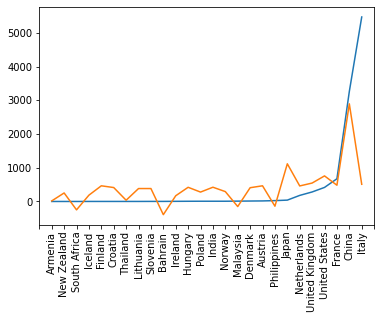

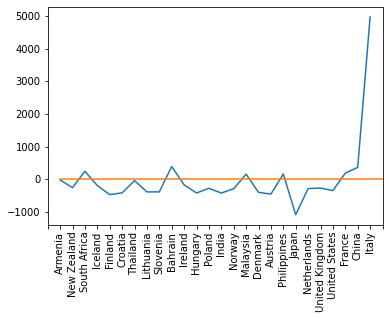

In [632]:
import numpy as np
ax = formodeling["totaldeaths"].plot()
pl.plot(totaldeaths.predict())
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.figure()
ax = (formodeling["totaldeaths"] - totaldeaths.predict()).plot()
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.plot([0,30], [0,0]);

In [633]:
totaldeaths = smf.ols(formula="totaldeaths ~ gdp + " + 
                          " testpp + "
                      "pop	+ growth	+ land	+ urban + age + totalinfected", 
                      data=formodeling).fit()
totaldeaths.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totaldeaths   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     183.8
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           8.74e-16
Time:                        23:05:40   Log-Likelihood:                -168.13
No. Observations:                  26   AIC:                             350.3
Df Residuals:                      19   BIC:                             359.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        55.6717    123.469      0.451      0.657    -202.751     314.094
gdp           -1.883e-10   5.54e-11     -3.398      0.003   -3.04e-10   -7.23e-11
testpp            0.1382      0.306      0.451      0.657      -0.503       0.779
pop           -5.192e-08   4.41e-07     -0.118      0.907   -9.74e-07    8.71e-07
growth         3.392e-07   4.42e-07      0.767      0.453   -5.87e-07    1.27e-06
land             -0.0005   7.22e-05     -7.171      0.000      -0.001      -0.000
urban             0.0072      0.001      6.168      0.000       0.005       0.010
age              -4.4486      7.744     -0.574      0.572     -20.657      11.759
totalinfected     0.0895      0.003     28.829      0.000       0.083       0.096
==============================================================================
Omnibus:                       26.899   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.330
Skew:                          -1.843   Prob(JB):                     2.40e-15
Kurtosis:                       9.969   Cond. No.                     1.49e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.59e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [637]:
logtotaldeaths1 = smf.ols(formula="np.log10(totaldeaths +1)~ gdp + " + 
                          " testpp + "
                      "pop	+ growth	+ land	+ urban + age + totalinfected", 
                      data=formodeling).fit()
logtotaldeaths1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     np.log10(totaldeaths + 1)   R-squared:                       0.828
Model:                                   OLS   Adj. R-squared:                  0.774
Method:                        Least Squares   F-statistic:                     15.25
Date:                       Mon, 23 Mar 2020   Prob (F-statistic):           2.35e-06
Time:                               23:06:28   Log-Likelihood:                -15.619
No. Observations:                         26   AIC:                             45.24
Df Residuals:                             19   BIC:                             54.04
Df Model:                                  6                                         
Covariance Type:                   nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9348      0.350      2.671      0.015       0.202       1.667
gdp            4.462e-13   1.57e-13      2.841      0.010    1.17e-13    7.75e-13
testpp            0.0023      0.001      2.666      0.015       0.000       0.004
pop           -2.634e-09   1.25e-09     -2.108      0.048   -5.25e-09   -1.92e-11
growth         3.874e-09   1.25e-09      3.089      0.006    1.25e-09     6.5e-09
land          -8.245e-07   2.05e-07     -4.032      0.001   -1.25e-06   -3.96e-07
urban         -1.559e-06    3.3e-06     -0.473      0.642   -8.47e-06    5.35e-06
age              -0.0160      0.022     -0.729      0.475      -0.062       0.030
totalinfected  4.893e-05    8.8e-06      5.559      0.000    3.05e-05    6.73e-05
==============================================================================
Omnibus:                        0.960   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.619   Jarque-Bera (JB):                0.633
Skew:                           0.375   Prob(JB):                        0.729
Kurtosis:                       2.857   Cond. No.                     1.49e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.59e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

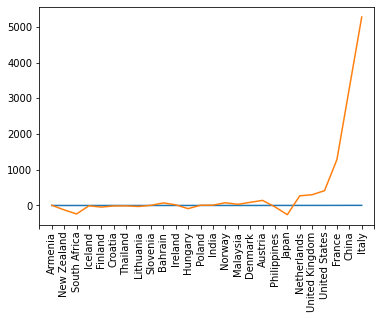

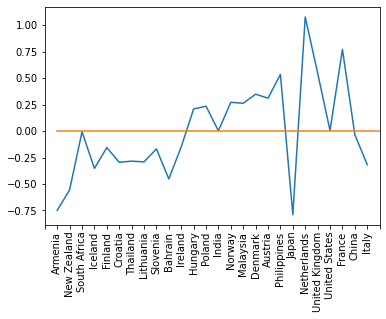

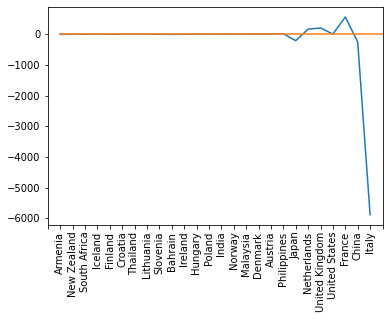

In [639]:
ax = np.log10(formodeling["totaldeaths"] + 1).plot()
pl.plot(totaldeaths.predict())
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.figure()
ax = (np.log10(formodeling["totaldeaths"] + 1) - logtotaldeaths1.predict()).plot()
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.plot([0,30], [0,0]);
pl.figure()
ax = ((formodeling["totaldeaths"]) - 10**logtotaldeaths1.predict()).plot()
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.plot([0,30], [0,0]);

In [640]:
totaldeaths2 = smf.ols(formula="totaldeaths ~ gdp + " + 
                      "pop	+ growth	+ land	+ urban + age + totalinfected +"
                      "testpp + teninfected", 
                      data=formodeling).fit()
totaldeaths2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totaldeaths   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     157.6
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           7.75e-15
Time:                        23:07:31   Log-Likelihood:                -167.44
No. Observations:                  26   AIC:                             350.9
Df Residuals:                      18   BIC:                             360.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -120.5344    215.850     -0.558      0.583    -574.019     332.950
gdp            -1.54e-10   6.53e-11     -2.359      0.030   -2.91e-10   -1.68e-11
pop            4.097e-06   7.07e-06      0.579      0.570   -1.08e-05     1.9e-05
growth        -3.757e-06   7.03e-06     -0.534      0.600   -1.85e-05     1.1e-05
land             -0.0005   7.67e-05     -7.085      0.000      -0.001      -0.000
urban             0.0067      0.001      5.389      0.000       0.004       0.009
age              -6.7055      8.071     -0.831      0.417     -23.661      10.250
totalinfected     0.0901      0.003     28.468      0.000       0.083       0.097
testpp           -0.2709      0.487     -0.556      0.585      -1.294       0.752
teninfected       3.3881      3.404      0.995      0.333      -3.763      10.540
==============================================================================
Omnibus:                       21.183   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.867
Skew:                          -1.448   Prob(JB):                     2.98e-10
Kurtosis:                       8.666   Cond. No.                     7.03e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

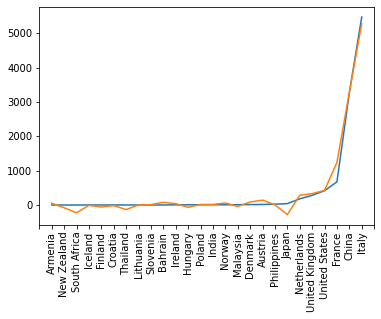

<Figure size 432x288 with 0 Axes>

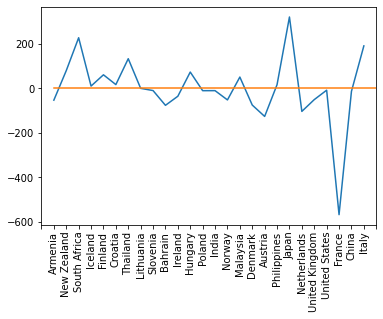

In [641]:
ax = formodeling["totaldeaths"].plot()
pl.plot(totaldeaths2.predict())
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.figure()
pl.figure()
ax = ((formodeling["totaldeaths"]) - totaldeaths2.predict()).plot()
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.plot([0,30], [0,0]);

In [642]:
logtotaldeaths2 = smf.ols(formula="np.log10(totaldeaths + 1) ~ gdp + " + 
                      "pop	+ growth	+ land	+ urban + age + totalinfected +"
                      "testpp + teninfected", 
                      data=formodeling).fit()
totaldeaths2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totaldeaths   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     157.6
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           7.75e-15
Time:                        23:07:37   Log-Likelihood:                -167.44
No. Observations:                  26   AIC:                             350.9
Df Residuals:                      18   BIC:                             360.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -120.5344    215.850     -0.558      0.583    -574.019     332.950
gdp            -1.54e-10   6.53e-11     -2.359      0.030   -2.91e-10   -1.68e-11
pop            4.097e-06   7.07e-06      0.579      0.570   -1.08e-05     1.9e-05
growth        -3.757e-06   7.03e-06     -0.534      0.600   -1.85e-05     1.1e-05
land             -0.0005   7.67e-05     -7.085      0.000      -0.001      -0.000
urban             0.0067      0.001      5.389      0.000       0.004       0.009
age              -6.7055      8.071     -0.831      0.417     -23.661      10.250
totalinfected     0.0901      0.003     28.468      0.000       0.083       0.097
testpp           -0.2709      0.487     -0.556      0.585      -1.294       0.752
teninfected       3.3881      3.404      0.995      0.333      -3.763      10.540
==============================================================================
Omnibus:                       21.183   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.867
Skew:                          -1.448   Prob(JB):                     2.98e-10
Kurtosis:                       8.666   Cond. No.                     7.03e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

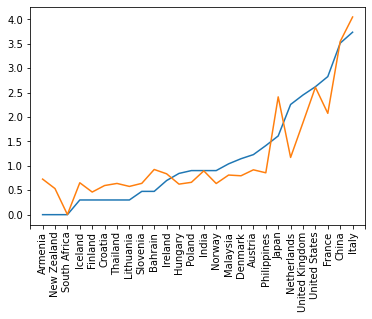

<Figure size 432x288 with 0 Axes>

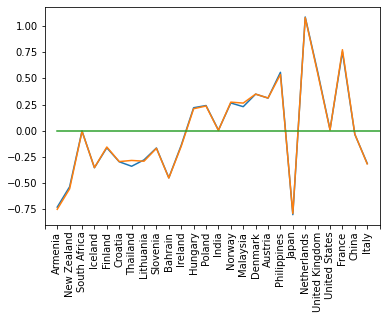

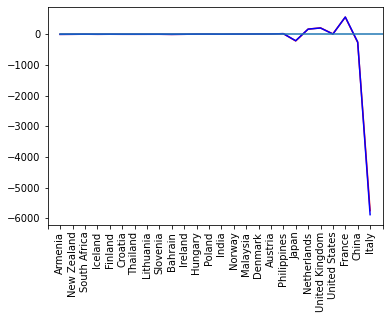

In [643]:
ax = np.log10(formodeling["totaldeaths"] + 1).plot()
pl.plot(logtotaldeaths2.predict())
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.figure()
pl.figure()
ax = (np.log10(formodeling["totaldeaths"] + 1) - logtotaldeaths2.predict()).plot()
(np.log10(formodeling["totaldeaths"] + 1) - logtotaldeaths1.predict()).plot(ax=ax)
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.plot([0,30], [0,0]);
pl.figure()
ax = (formodeling["totaldeaths"] - 10**logtotaldeaths2.predict()).plot(c='r')
(formodeling["totaldeaths"] - 10**logtotaldeaths1.predict()).plot(ax=ax, c='b')
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.plot([0,30], [0,0]);

In [644]:
import sklearn
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor
y = np.log10(formodeling[["totaldeaths"]] + 1)
features = ["gdp","pop","growth","land","urban","age","totalinfected",
                "testpp","teninfected"]
X = formodeling[features]
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(X, y)
print(regr.feature_importances_);
print(regr.predict(X));

[0.06993613 0.02447148 0.02787627 0.00652076 0.03120869 0.01503162
 0.78251975 0.0169902  0.0254451 ]
[0.17639377 0.16933489 0.36117476 0.39469587 0.52449671 0.3266368
 0.53877773 0.32270475 0.44726434 0.44702923 0.80885479 0.70321324
 0.81515519 1.01186379 0.92883785 0.97152505 1.02140715 1.19848096
 1.00593798 1.37654644 1.96328938 2.29425813 2.72216513 2.75191037
 3.27601908 3.35647793]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


In [645]:
regr.score(X, y)

0.9682134031170522

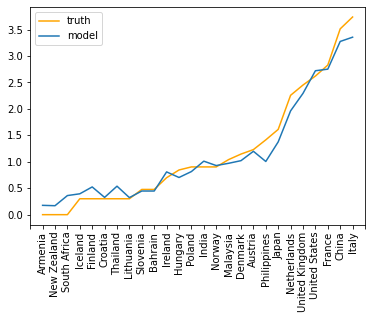

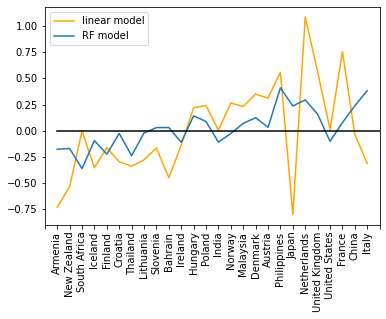

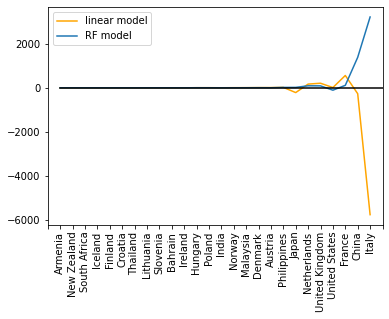

In [646]:
ax = np.log10(formodeling["totaldeaths"] + 1).plot(label="truth", c="orange")
pl.plot(regr.predict(X), label="model")
pl.legend()
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.figure()

ax = (np.log10(formodeling["totaldeaths"] + 1) - 
      logtotaldeaths2.predict()).plot(label="linear model", c="orange")
(np.log10(formodeling["totaldeaths"] + 1) - 
 regr.predict(X)).plot(ax=ax, label="RF model")
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.plot([0,30], [0,0], color='k');
pl.legend()

pl.figure()
ax = (formodeling["totaldeaths"] - 
      10**logtotaldeaths2.predict()).plot(label="linear model", c="orange")
(formodeling["totaldeaths"] - 
 10**regr.predict(X)).plot(ax=ax, label="RF model")
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);
pl.plot([0,30], [0,0], color='k');
pl.legend()


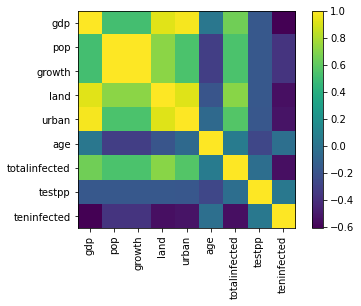

In [647]:
covMatrix = np.corrcoef(X.T)
pl.imshow((covMatrix))
pl.colorbar()
pl.xticks(range(len(features)), features, rotation=90)
pl.yticks(range(len(features)), features);

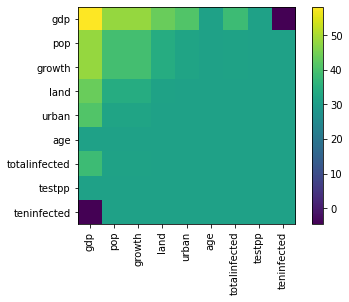

In [648]:
covMatrix = np.cov(X.T)
pl.imshow(np.log(covMatrix - covMatrix.min() + 0.01))
pl.colorbar()
pl.xticks(range(len(features)), features, rotation=90)
pl.yticks(range(len(features)), features);

In [649]:
importances = regr.feature_importances_
importances


std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
importances[indices]

array([0.78251975, 0.06993613, 0.03120869, 0.02787627, 0.0254451 ,
       0.02447148, 0.0169902 , 0.01503162, 0.00652076])

Feature ranking:
1. feature totalinfected (0.782520)
2. feature gdp (0.069936)
3. feature urban (0.031209)
4. feature growth (0.027876)
5. feature teninfected (0.025445)
6. feature pop (0.024471)
7. feature testpp (0.016990)
8. feature age (0.015032)
9. feature land (0.006521)


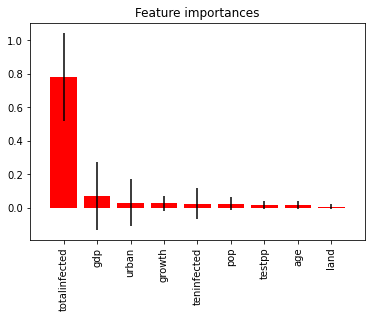

In [650]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, np.array(features)[indices][f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

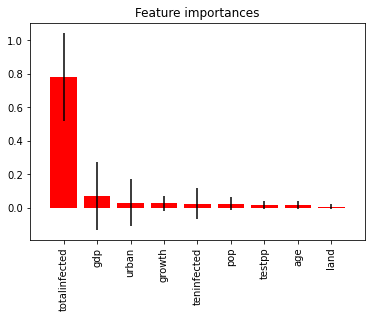

Feature ranking:
1. feature totalinfected (0.000051)
2. feature land (0.001857)
3. feature gdp (0.035943)
4. feature growth (0.115973)
5. feature testpp (0.123213)
6. feature Intercept (0.123293)
7. feature pop (0.130918)
8. feature age (0.531537)
9. feature urban (0.713797)


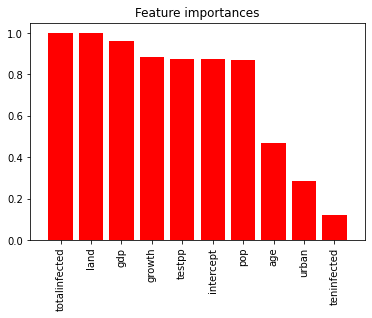

In [651]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]),  np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

importances = logtotaldeaths2.pvalues.values

indices = np.argsort(importances)

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, 
        logtotaldeaths2.pvalues.index[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1] + 1), 1 - importances[indices],
       color="r",  align="center")
plt.xticks(range(X.shape[1] + 1), 
           list(np.array(["intercept"] + features)[indices]), 
rotation=90)
plt.xlim([-1, X.shape[1] + 1])
plt.show()



In [652]:
totaldeaths = smf.ols(formula="np.log10(totaldeaths +1)~ gdp + " + 
                      "pop	+ growth	+ land	+ urban + age + totalinfected + teninfected", 
                      data=formodeling).fit()
totaldeaths.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     np.log10(totaldeaths + 1)   R-squared:                       0.828
Model:                                   OLS   Adj. R-squared:                  0.762
Method:                        Least Squares   F-statistic:                     12.40
Date:                       Mon, 23 Mar 2020   Prob (F-statistic):           9.68e-06
Time:                               23:08:27   Log-Likelihood:                -15.601
No. Observations:                         26   AIC:                             47.20
Df Residuals:                             18   BIC:                             57.27
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0153      0.628      1.617      0.123      -0.304       2.335
gdp            4.305e-13    1.9e-13      2.267      0.036    3.15e-14    8.29e-13
pop           -3.256e-08   2.06e-08     -1.583      0.131   -7.58e-08    1.07e-08
growth         3.378e-08   2.05e-08      1.652      0.116   -9.19e-09    7.67e-08
land          -8.127e-07   2.23e-07     -3.644      0.002   -1.28e-06   -3.44e-07
urban         -1.354e-06   3.63e-06     -0.373      0.714   -8.99e-06    6.28e-06
age              -0.0150      0.023     -0.638      0.532      -0.064       0.034
totalinfected  4.865e-05   9.21e-06      5.281      0.000    2.93e-05     6.8e-05
teninfected      -0.0015      0.010     -0.156      0.878      -0.022       0.019
==============================================================================
Omnibus:                        1.029   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                0.682
Skew:                           0.390   Prob(JB):                        0.711
Kurtosis:                       2.861   Cond. No.                     6.89e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [653]:
dead2test = smf.ols(formula="dead2test ~ " + 
                    "totalinfected + gdp +	pop	+growth	+ land + " + 
                    "urban +  age + tests", data=formodeling).fit()
dead2test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dead2test   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     6.517
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           0.000634
Time:                        23:08:31   Log-Likelihood:                 77.455
No. Observations:                  26   AIC:                            -138.9
Df Residuals:                      18   BIC:                            -128.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0173      0.010      1.716      0.103      -0.004       0.038
totalinfected  4.563e-06   9.15e-07      4.989      0.000    2.64e-06    6.49e-06
gdp            3.149e-14   9.05e-15      3.479      0.003    1.25e-14    5.05e-14
pop            6.716e-11   2.06e-11      3.258      0.004    2.39e-11     1.1e-10
growth         1.229e-11   1.93e-11      0.638      0.532   -2.82e-11    5.28e-11
land           2.902e-08   1.39e-08      2.094      0.051   -9.09e-11    5.81e-08
urban         -1.248e-06   3.81e-07     -3.277      0.004   -2.05e-06   -4.48e-07
age              -0.0007      0.001     -1.079      0.295      -0.002       0.001
tests         -2.071e-06   5.36e-07     -3.867      0.001    -3.2e-06   -9.46e-07
==============================================================================
Omnibus:                       16.994   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.377
Skew:                           1.408   Prob(JB):                     1.38e-05
Kurtosis:                       6.567   Cond. No.                     1.60e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.26e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

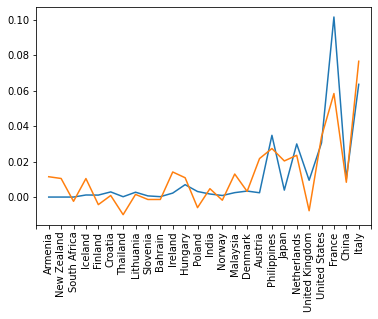

In [654]:
ax = formodeling["dead2test"].plot()
pl.plot(dead2test.predict())
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);


In [655]:
infected2test = smf.ols(formula="infected2test ~ " + 
                        "totalinfected + gdp +	pop	+ growth + " + 
                        "land	+ urban + age + tests", data=formodeling).fit()
infected2test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          infected2test   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     6.839
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           0.000477
Time:                        23:08:37   Log-Likelihood:                -6.5142
No. Observations:                  26   AIC:                             29.03
Df Residuals:                      18   BIC:                             39.09
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4123      0.254      1.622      0.122      -0.122       0.946
totalinfected  9.238e-05   2.31e-05      3.997      0.001    4.38e-05       0.000
gdp            6.431e-13   2.29e-13      2.812      0.012    1.63e-13    1.12e-12
pop            1.159e-09   5.21e-10      2.225      0.039    6.48e-11    2.25e-09
growth        -1.561e-10   4.87e-10     -0.321      0.752   -1.18e-09    8.67e-10
land           1.122e-06    3.5e-07      3.204      0.005    3.86e-07    1.86e-06
urban         -2.921e-05   9.62e-06     -3.036      0.007   -4.94e-05   -8.99e-06
age               0.0018      0.016      0.111      0.913      -0.032       0.035
tests         -5.114e-05   1.35e-05     -3.778      0.001   -7.96e-05   -2.27e-05
==============================================================================
Omnibus:                       12.470   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.222
Skew:                           1.208   Prob(JB):                      0.00222
Kurtosis:                       5.333   Cond. No.                     1.60e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.26e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

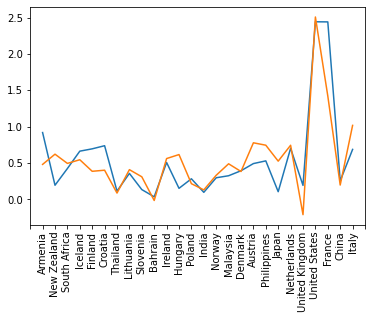

In [656]:
ax = formodeling["infected2test"].plot()
pl.plot(infected2test.predict())
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);


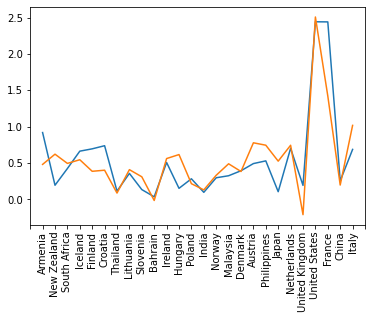

In [657]:
ax = formodeling["infected2test"].plot()
pl.plot(infected2test.predict())
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);


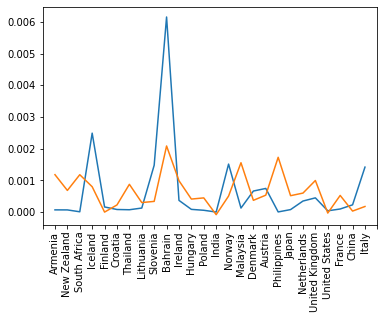

In [658]:
ax = formodeling["testpp"].plot()
pl.plot(testpp.predict())
ax.set_xticks(np.arange(-1, len(formodeling) + 1))
              # labels=formodeling["Country Name"].values)
ax.set_xticklabels(labels= [''] + list(
    formodeling["Country Name"].values), rotation=90);

In [659]:
infected

Country/Region      Lat      Long  ...  2020-03-21  2020-03-22  teninfected
0      Afghanistan  33.0000   65.0000  ...          24          40         73.0
1          Albania  41.1533   20.1683  ...          76          89         70.0
2          Algeria  28.0339    1.6596  ...         139         201         63.0
3          Andorra  42.5063    1.5218  ...          88         113         76.0
4           Angola -11.2027   17.8739  ...           2           2          NaN
..             ...      ...       ...  ...         ...         ...          ...
166     Uzbekistan  41.3775   64.5853  ...          43          43         77.0
167      Venezuela   6.4238  -66.5897  ...          70          70         75.0
168        Vietnam  16.0000  108.0000  ...          94         113         38.0
169         Zambia -15.4167   28.2833  ...           2           3          NaN
170       Zimbabwe -20.0000   30.0000  ...           3           3          NaN

[171 rows x 127 columns]

# Greg Dobler's analysis of the rate of infection

this par tof the analysis was performed by Greg Dobler (my husband and a colleague) on the evidence of a rutn over in the infection rate in various countries: China as a benchmark, Italy and the US, the countries we have a connection to


In [0]:

datag = infected.set_index("Country/Region").iloc[:, 2:N+2].T

In [0]:
datag.index = pd.to_datetime(datag.index)


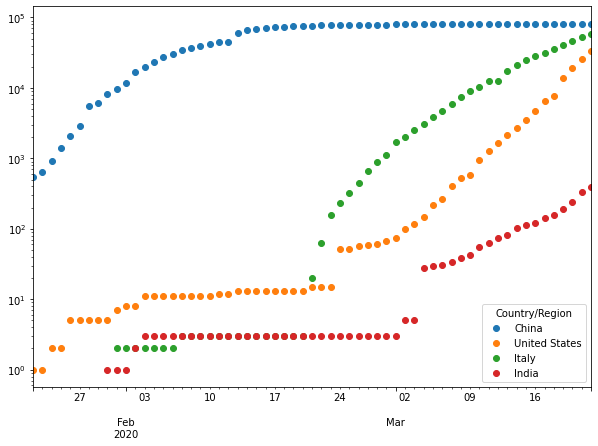

In [665]:
datag.plot(y=["China", "United States", "Italy", "India"], use_index=True, 
           figsize=[10, 7], logy=True, style="o");

 ---

### **China: the infection rate turned around**

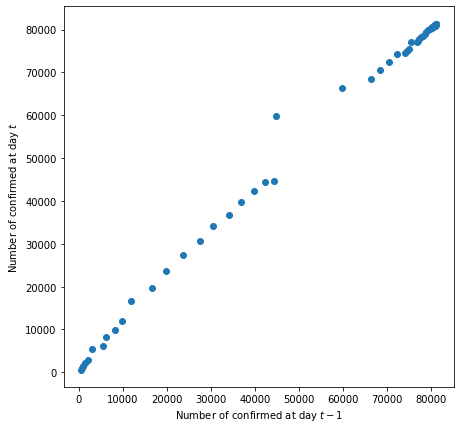

In [666]:
# -- plot day vs day-1
fig, ax = plt.subplots(figsize=[7, 7])
ax.scatter(datag[:]["China"].values[:-1], datag[:]["China"].values[1:])
ax.set_xlabel("Number of confirmed at day $t - 1$")
ax.set_ylabel("Number of confirmed at day $t$")
fig.show()

In [0]:
# -- fit two models

china_sub = datag[:]["China"].reset_index()
china_sub.columns = ["date", "counts"]
china_sub["day"] = np.arange(len(china_sub))
china_sub["lcounts"] = np.log10(china_sub["counts"])

lm0 = smf.ols("lcounts ~ day", data=china_sub)
lm1 = smf.ols("lcounts ~ day + np.power(day, 2)", data=china_sub)

res0 = lm0.fit()
res1 = lm1.fit()

pred0 = res0.predict(china_sub)
pred1 = res1.predict(china_sub)

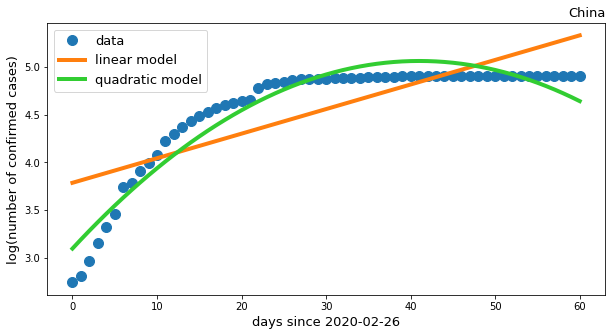

In [668]:
# -- plot results
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(china_sub["day"], china_sub["lcounts"], "o", ms=10, label="data")
ax.plot(china_sub["day"], pred0, lw=4, label="linear model")
ax.plot(china_sub["day"], pred1, lw=4, c="limegreen", label="quadratic model")
ax.set_xlabel("days since 2020-02-26", fontsize=13)
ax.set_ylabel("log(number of confirmed cases)", fontsize=13)
ax.set_title("China", loc="right", fontsize=13)
ax.legend(fontsize=13)
fig.show()

In [669]:
# -- likelihood ratio test
lr, pval, ddf = res1.compare_lr_test(res0)

print("the integrated probability that the observed likelihood ratio \n" + 
      "occurred by random chance is {0:.2g}".format(pval))

the integrated probability that the observed likelihood ratio 
occurred by random chance is 5e-24


---

### **US: no evidence or turnover yet**

In [0]:
# -- subset US
us_sub = datag[datag.index > "2020-02-29"]["United States"].reset_index()
us_sub.columns = ["date", "counts"]
us_sub["day"] = np.arange(len(us_sub))
us_sub["lcounts"] = np.log10(us_sub["counts"])

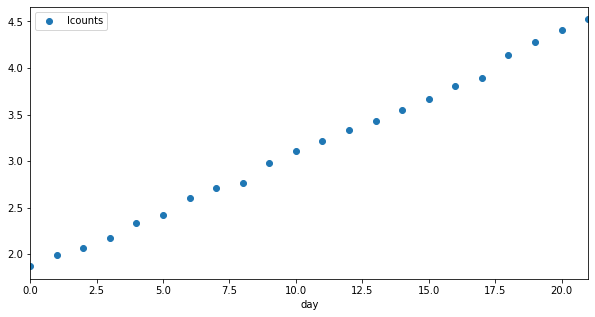

In [671]:
# -- plot it
us_sub.plot("day", "lcounts", style="o", figsize=[10, 5]);

In [0]:
# -- fit two models
lm0 = smf.ols("lcounts ~ day", data=us_sub)
lm1 = smf.ols("lcounts ~ day + np.power(day, 2)", data=us_sub)

res0 = lm0.fit()
res1 = lm1.fit()

pred0 = res0.predict(us_sub)
pred1 = res1.predict(us_sub)

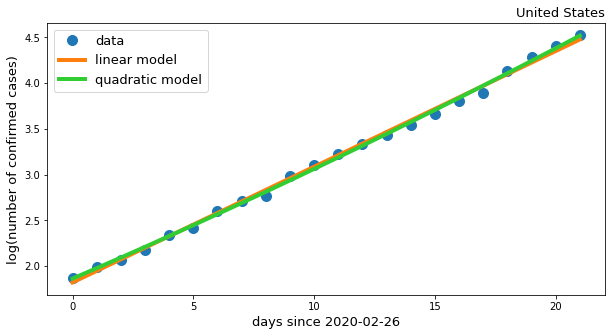

In [673]:
# -- plot results
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(us_sub["day"], us_sub["lcounts"], "o", ms=10, label="data")
ax.plot(us_sub["day"], pred0, lw=4, label="linear model")
ax.plot(us_sub["day"], pred1, lw=4, c="limegreen", label="quadratic model")
ax.set_xlabel("days since 2020-02-26", fontsize=13)
ax.set_ylabel("log(number of confirmed cases)", fontsize=13)
ax.set_title("United States", loc="right", fontsize=13)
ax.legend(fontsize=13)
fig.show()

In [674]:
# -- likelihood ratio test
lr, pval, ddf = res1.compare_lr_test(res0)

print("the integrated probability that the observed likelihood ratio \n" + 
      "occurred by random chance is {0:.2g}".format(pval))

the integrated probability that the observed likelihood ratio 
occurred by random chance is 0.0071


---

### **Italy: just turned around!**

In [0]:
# -- subset Italy
it_sub = datag[datag.index > "2020-02-29"]["Italy"].reset_index()
it_sub.columns = ["date", "counts"]
it_sub["day"] = np.arange(len(it_sub))
it_sub["lcounts"] = np.log10(it_sub["counts"])

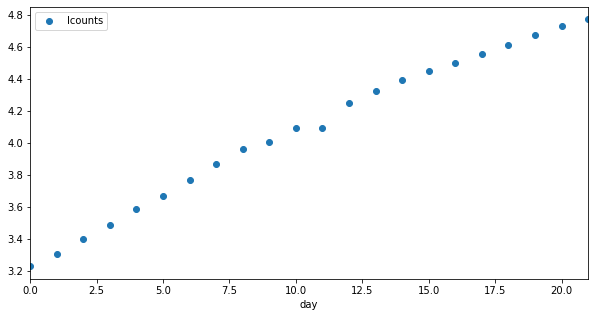

In [676]:
# -- plot it
it_sub.plot("day", "lcounts", style="o", figsize=[10, 5]);

In [0]:
# -- fit two models
lm0 = smf.ols("lcounts ~ day", data=it_sub)
lm1 = smf.ols("lcounts ~ day + np.power(day, 2)", data=it_sub)

res0 = lm0.fit()
res1 = lm1.fit()

pred0 = res0.predict(it_sub)
pred1 = res1.predict(it_sub)

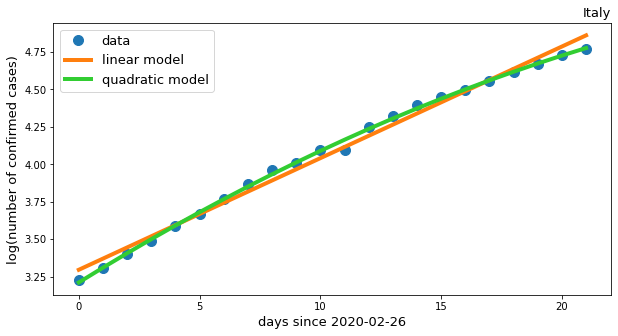

In [678]:
# -- plot results
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(it_sub["day"], it_sub["lcounts"], "o", ms=10, label="data")
ax.plot(it_sub["day"], pred0, lw=4, label="linear model")
ax.plot(it_sub["day"], pred1, lw=4, c="limegreen", label="quadratic model")
ax.set_xlabel("days since 2020-02-26", fontsize=13)
ax.set_ylabel("log(number of confirmed cases)", fontsize=13)
ax.set_title("Italy", loc="right", fontsize=13)
ax.legend(fontsize=13)
fig.show()

In [679]:
# -- likelihood ratio test
lr, pval, ddf = res1.compare_lr_test(res0)

print("the integrated probability that the observed likelihood ratio \n" + 
      "occurred by random chance is {0:.2g}".format(pval))

the integrated probability that the observed likelihood ratio 
occurred by random chance is 1.8e-10
